In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import soundfile as sf
from scipy.signal import butter, filtfilt, hilbert, spectrogram, freqz, sosfiltfilt, find_peaks, sosfilt
from scipy.ndimage import gaussian_filter1d
from IPython.display import Audio, display

# Calibration

## MRM 1 - JPM 

In [12]:
# load FLAC file
input_flac_file = "ManualRockMovements-1/audio/Nicole_091823-000100.flac"
data, samplerate = sf.read(input_flac_file)

# if stereo (more than one channel), keep only one channel
if data.ndim > 1:
    data = data[:,0] # keep the left channel, which in this case is the impact pipe

Gain Compensation

Sampling Rate: 44100 Hz
Original data shape: (52920000,)
Linear gain factor: 14.13


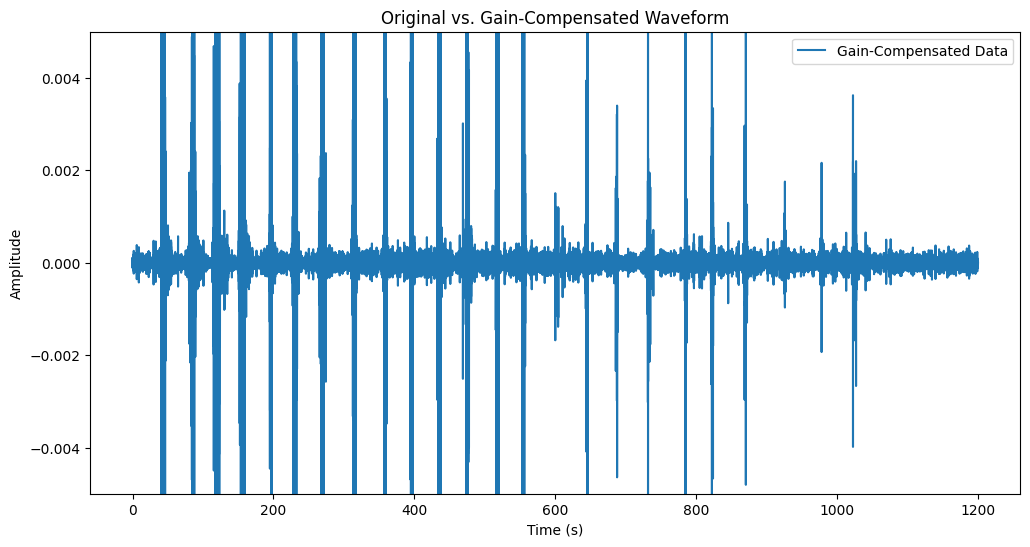

In [17]:
preamp_gain_db = 23  # preamp gain in dB for this recording
linear_gain = 10**(preamp_gain_db / 20)
calibrated_data = data / linear_gain

print(f"Sampling Rate: {samplerate} Hz")
print(f"Original data shape: {data.shape}")
print(f"Linear gain factor: {linear_gain:.2f}")

# plot the raw and calibrated waveforms for verification
time = np.arange(len(data)) / samplerate
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))
#plt.plot(time, data, label="Raw Digital Data")
plt.plot(time, calibrated_data, label="Gain-Compensated Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs. Gain-Compensated Waveform")
plt.legend(loc='upper right')
plt.ylim(-0.005, 0.005)
# saving instead of showing to avoid space usage issues
#plt.savefig("calibration_plots/MRM1/test_waveform_comparison.png", dpi=300)
plt.show()

Spectrogram (for frequency high and low cut selection)

In [4]:
# commenting this out because it takes so long to run
frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)
plt.figure(figsize=(15, 6))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensity [dB]') 
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Acoustic Signal Spectrogram')
plt.ylim([0, samplerate / 2])  # limit y-axis to Nyquist frequency
plt.savefig("calibration_plots/MRM1/test_spectrogram.png", dpi=300)
plt.close()

MemoryError: Unable to allocate 5.41 GiB for an array with shape (120954880, 3, 2) and data type float64

Error in callback <function _draw_all_if_interactive at 0x000001C4BD857240> (for post_execute), with arguments args (),kwargs {}:


MemoryError: Unable to allocate 10.8 GiB for an array with shape (1024, 29530, 48) and data type float64

MemoryError: Unable to allocate 461. MiB for an array with shape (1024, 29530, 2) and data type float64

<Figure size 1500x600 with 2 Axes>

Time averaged frequency spectrum

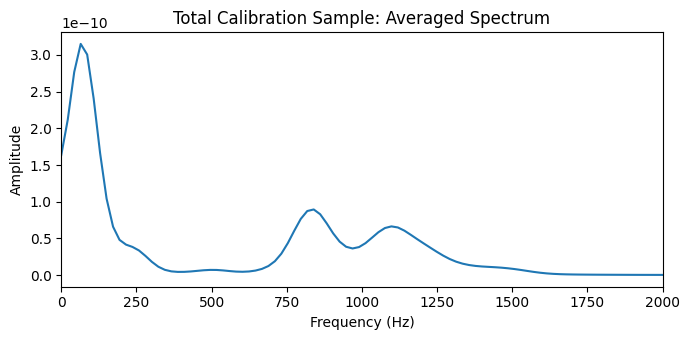

In [11]:
frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)

# average spectrum over time
cols = np.arange(len(times))
spec_avg = Sxx[:, cols].mean(axis=1)
spec_sm = gaussian_filter1d(spec_avg, 2) # smooth with gaussian filter; sigma=2

# plot the averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies, spec_sm, label="Smoothed avg spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: Averaged Spectrum")
plt.tight_layout()
plt.savefig("calibration_plots/MRM1/test_time_avg_spectrum.png", dpi=300)
plt.show()
#plt.close()

FFT frequency spectrum

In [7]:
# FFT-based frequency spectrum
fft_data = np.fft.fft(calibrated_data)
frequencies_fft = np.fft.fftfreq(len(calibrated_data), 1/samplerate)

# take only positive frequencies and convert to magnitude
positive_freq_mask = frequencies_fft >= 0
frequencies_fft = frequencies_fft[positive_freq_mask]
magnitude_spectrum = np.abs(fft_data[positive_freq_mask])
spec_sm_fft = gaussian_filter1d(magnitude_spectrum, 500)  # smooth with gaussian filter; sigma=500

# plot FFT-based averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies_fft, spec_sm_fft, label="Smoothed FFT spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: FFT-Based Spectrum")
plt.tight_layout()
plt.savefig("calibration_plots/MRM1/test_fft_spectrum.png", dpi=300)
plt.close()

Functions to select frequency band 

In [4]:
def band_sos(low, high, fs, order=5):
    nyq = 0.5 * fs
    lown = max(low / nyq, 1e-6) # avoid 0 or negative
    highn = min(high / nyq, 0.999999) # avoid >1
    return butter(order, [lown := lown, highn], btype='band', output='sos') # bandpass filter

def apply_band_and_energy(x, fs, band, order=4):
    low, high = band 
    sos = band_sos(low, high, fs, order=order)
    y = sosfiltfilt(sos, x)
    # energy (RMS^2) overall and in sliding windows if desired
    energy = np.mean(y**2)
    return y, energy

def band_test_and_plot(x, fs, bands, event_window=None, quiet_window=None, nperseg=2048, noverlap=None):
    if noverlap is None:
        noverlap = nperseg // 2
    results = {}
    for band in bands:
        y, energy = apply_band_and_energy(x, fs, band)
        # compute spectrogram for plotting
        f, t, Sxx = spectrogram(y, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, scaling='density', mode='magnitude')
        results[band] = {'y': y, 'energy': energy, 'f': f, 't': t, 'Sxx': Sxx}

    # compute event and quiet band energies if windows provided
    if event_window is not None:
        t0, t1 = event_window
        idx0 = int(t0 * fs); idx1 = int(t1 * fs)
    else:
        idx0, idx1 = 0, len(x)
    if quiet_window is not None:
        q0, q1 = quiet_window
        qidx0, qidx1 = int(q0*fs), int(q1*fs)
    else:
        # pick a quiet stretch before the event if possible
        qidx0, qidx1 = 0, min(int(0.5*fs), len(x))

    print("Band energy summary (mean squared) and event/quiet ratios:")
    eps = np.finfo(float).eps # small number to avoid div by 0
    for band, info in results.items():
        y = info['y'] # band-passed signal
        event_energy = np.mean(y[idx0:idx1]**2) # average power during event
        quiet_energy = np.median(y[qidx0:qidx1]**2)     # robust noise estimate
        quiet_energy = max(quiet_energy, eps)           # avoid division by 0
        ratio = event_energy / quiet_energy
        snr_db = 10.0 * np.log10(ratio)
        print(f"{band[0]:4.0f}-{band[1]:4.0f} Hz:"
            f" total {info['energy']:.3e},"
            f" event_power {event_energy:.3e},"
            f" quiet_power {quiet_energy:.3e},"
            f" ratio {ratio:.2f}, snr={snr_db:.1f} dB")

    # plot spectrograms side-by-side for visual comparison
    n = len(bands)
    plt.figure(figsize=(12, 3*n))
    for i, band in enumerate(bands, start=1):
        info = results[band]
        plt.subplot(n, 1, i)
        plt.pcolormesh(info['t'], info['f'], 10*np.log10(info['Sxx'] + 1e-12), shading='auto')
        plt.ylim(0, min(3000, fs/2))
        plt.title(f"Band {band[0]}-{band[1]} Hz spectrogram")
        plt.ylabel("Freq (Hz)")
        plt.colorbar(label='dB')
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

    return results

In [ ]:
bands = [(20,300), (700,1500), (20,2000)]
results = band_test_and_plot(calibrated_data, samplerate, bands, event_window=(35,850), quiet_window=(1100,1200))

Play filtered recordings for verification

In [ ]:
# play original
# normalize to avoid clipping
def play_array(x, fs, norm=True):
    xr = x / (np.max(np.abs(x)) + 1e-12) if norm else x
    display(Audio(xr, rate=fs))


play_array(calibrated_data, samplerate)

In [ ]:
# low band (20-200 Hz)
low = apply_band_and_energy(calibrated_data, samplerate, (20,200))[0] 
play_array(low, samplerate)

In [ ]:
# mid band (700-1500 Hz)
mid = apply_band_and_energy(calibrated_data, samplerate, (700,1500))[0]
play_array(mid, samplerate)

In [ ]:
# full band (20-2000 Hz)
full = apply_band_and_energy(calibrated_data, samplerate, (20,2000))[0]
play_array(full, samplerate)

### Band-Pass Filtering 

Filter Order Selection

In [6]:
def band_pass_filter(data, samplerate, low, high, order):
    nyquist = 0.5 * samplerate
    low = low / nyquist
    high = high / nyquist
    b, a = butter(order, [low, high], btype='band') # get filter coefficients
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [ ]:
# plotting the filters
lowcut = 700       # low cutoff frequency (Hz)
highcut = 1500       # high cutoff frequency (Hz)
orders = [3, 4, 5, 6]  # filter orders to compare
nyquist = 0.5 * samplerate
plt.figure(figsize=(7, 4))

for order in orders:
    # get the filter coefficients
    b, a = butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')
    # calculate the frequency response
    w, h = freqz(b, a, worN=2000) # worN determines the number of points at which to evaluate the response

    # convert angular frequency to Hz and magnitude to a linear scale (0-1)
    frequencies = w * samplerate / (2 * np.pi)
    magnitude_response = np.abs(h)

    # plot the magnitude response
    plt.plot(frequencies, magnitude_response, label=f'Order {order}')

# add vertical line at cutoff frequencies
plt.axvline(lowcut, color='gray', linestyle='--', label='Low Cutoff')
plt.axvline(highcut, color='gray', linestyle='--', label='High Cutoff')
plt.title('Butterworth Band-Pass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.xlim(0, 3000)  # Adjust x-axis limits to better visualize the passband
plt.ylim(0, 1.1)   # Adjust y-axis limits
plt.savefig("calibration_plots/MRM1/test_bandpass_filter.png", dpi=300)
plt.close()

In [ ]:
lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

data_3 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=3)
data_4 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
data_5 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=5)

In [ ]:
# visualize the filtered signal
plt.figure(figsize=(12, 6))
plt.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)
plt.plot(time, data_3, label="Order 3", color='blue', alpha=0.5)
plt.plot(time, data_4, label="Order 4", color='green', alpha=0.5)
plt.plot(time, data_5, label="Order 5", color='red', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
plt.legend(loc='upper right')
plt.savefig("calibration_plots/MRM1/test_bandpass_filtered_signal.png", dpi=300)
plt.close()

Subsample for noise detection

In [ ]:
# individual impact - between 39 and 49 seconds
subsample = calibrated_data[int(39 * samplerate):int(49 * samplerate)]
sub3 = data_3[int(39 * samplerate):int(49 * samplerate)]
sub5 = data_5[int(39 * samplerate):int(49 * samplerate)]
subtime = np.arange(len(subsample)) / samplerate

In [ ]:
# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(subtime, subsample, label="Original", color='orange', alpha=0.7)
plt.plot(subtime, sub5, label="Order 5", color='red', alpha=0.6)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
plt.ylim(-0.01, 0.01)
plt.legend(loc='upper right')
plt.savefig("calibration_plots/MRM1/test_subsample_bandpass_filtered_signal.png", dpi=300)
plt.close()

Filter Data and Amplify 

In [7]:
lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

# first band-pass filter the entire calibrated data
filtered_data1 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
filtered_data2 = filtered_data1 * 20

# second band-pass filter
filtered_data3 = band_pass_filter(filtered_data2, samplerate, lowcut, highcut, order=4)
filtered_data = filtered_data3 * 10

In [ ]:
# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(time, filtered_data2, label="Filtered (1st)", color='red', alpha=0.7)
plt.plot(time, filtered_data3, label="Filtered (2nd)", color='blue', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signals (Without Amplification)")
plt.legend(loc='upper right')
twin = plt.twinx()
twin.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)

#plt.xlim(41.2, 42)  # zoom in to see details
plt.savefig("calibration_plots/MRM1/test_bandpass_filtered_signals_full.png", dpi=300)
plt.close()

In [ ]:
# DELETING VARIABLES NOT NEEDED ANYMORE
del data, calibrated_data, data_3, data_4, data_5
del sub3, sub5, h, cols, fft_data, frequencies_fft, 
del magnitude_spectrum, spec_sm_fft, full, positive_freq_mask
del filtered_data1, filtered_data2, filtered_data3, lowcut, highcut
del orders, b, a, w, frequencies, times
del twin, spec_sm, spec_avg, magnitude_response, results, input_flac_file

### Envelope Detection

Subsample for envelope

In [ ]:
subsample = filtered_data[int(41.35 * samplerate):int(41.85* samplerate)]
subtime = np.arange(len(subsample)) / samplerate

# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(subtime, subsample, label="Filtered", color='orange', alpha=0.5)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
#plt.ylim(-0.1, 0.1)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# using the hilbert transform 
analytic_signal = hilbert(subsample)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 300 # # low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(subsample))

# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(subtime, subsample, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(subtime, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(subtime, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope: Zoomed in subsample")
plt.legend()
plt.xlim(0.26, 0.3)
plt.savefig("calibration_plots/MRM1/test_signal_envelopes_zoomed_single.png", dpi=300)
plt.show()


Full Sample

In [8]:
# using the hilbert transform 
nyquist = 0.5 * samplerate
analytic_signal = hilbert(filtered_data)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 100 # # low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(filtered_data))

In [ ]:
# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, filtered_data, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(time, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope")
plt.legend(loc='upper right')
#plt.xlim(42.4, 42.7)
#plt.ylim(-5, 5)
plt.savefig("calibration_plots/MRM1/test_signal_envelopes_full.png", dpi=300)
plt.show()

### Pulse counting and Rectangular waveform

Compute and plot the rectangular waveforms

In [9]:
# channel gains (relative multipliers) from 
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

# voltage thresholds for impulse detection
lower_thresh = 2  # volts

# first column of results is the time index of detected impulses
rect_hilbert = pd.DataFrame({'time': time})
rect_rectified = pd.DataFrame({'time': time})

# loop over channels, apply gain, and detect impulses
# for hilbert envelope
for ch, gain in gains.items():
    amplified = envelope_hilbert * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_hilbert[f'ch{ch}'] = rectangular

# for rectified envelope
for ch, gain in gains.items():
    amplified = envelope_rectified * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_rectified[f'ch{ch}'] = rectangular

del amplified, binary, rectangular, ch, gain

In [ ]:
# visualize rect waveforms from hilbert envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000  

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_hilbert['time'][::downsample_factor]
    downsampled_signal = rect_hilbert[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Hilbert Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/MRM1/test_rect_from_hilbert_subplots.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# visualize rect waveforms from rectified envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000 

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_rectified['time'][::downsample_factor]
    downsampled_signal = rect_rectified[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Rectified Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/MRM1/test_rect_from_rectified_subplots.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, envelope_hilbert*16, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, rect_hilbert['ch4'], 'r-', linewidth=2, label='Rectangular Waveform')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.title("Hilbert Envelope and Rectangular Waveform (Ch4 - Gain x16)")
plt.legend(loc='upper right')
plt.xlim(42.45, 42.57)
plt.ylim(-1, 20)
plt.savefig("calibration_plots/MRM1/test_signal_envelopes_sub.png", dpi=300)
plt.show()

In [ ]:
# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, envelope_rectified*16, 'g-', linewidth=2, label='Rectified Envelope')
plt.plot(time, rect_rectified['ch4'], 'r-', linewidth=2, label='Rectangular Waveform')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.title("Rectified Envelope and Rectangular Waveform (Ch4 - Gain x16)")
plt.legend(loc='upper right')
plt.xlim(42.45, 42.57)
plt.ylim(-1, 20)
#plt.savefig("calibration_plots/test/test_signal_envelopes_full.png", dpi=300)
plt.show()

Counting pulses by particle impact 

In [10]:
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

fs = samplerate  # sampling frequency (Hz)
dt = 1.0         # target bin size in seconds

# build bins
time_bins = np.arange(time[0], time[-1] + dt, dt)
time_index = pd.to_timedelta(time_bins[:-1], unit="s")

# function to count impulses (rising edges) per second
def count_impulses(rect_signal, fs):
    # detect rising edges: 0→5 transitions
    rising_edges = np.diff((rect_signal > 0).astype(int)) == 1
    edge_times = time[1:][rising_edges]
    # bin counts into 1s intervals
    counts, _ = np.histogram(edge_times, bins=time_bins)
    return counts

# prepare output containers
results_hilbert = pd.DataFrame(index=time_index)
results_rectified = pd.DataFrame(index=time_index)
df_env = pd.DataFrame(index=pd.to_timedelta(time, unit="s"))

# 1) count impulses
for ch, gain in gains.items():
    impulses = count_impulses(rect_hilbert[f"ch{ch}"].values, fs)
    results_hilbert[f"impulses_ch{ch}"] = impulses

    impulses = count_impulses(rect_rectified[f"ch{ch}"].values, fs)
    results_rectified[f"impulses_ch{ch}"] = impulses
    # per-channel rect (0–5 V pulse train)
    df_env[f"hil_rect_ch{ch}"] = rect_hilbert[f"ch{ch}"]
    df_env[f"rect_rect_ch{ch}"] = rect_rectified[f"ch{ch}"]
    # per-channel envelope (apply gain to original envelopes)
    df_env[f"hil_env_ch{ch}"] = envelope_hilbert * gain
    df_env[f"rect_env_ch{ch}"] = envelope_rectified * gain

# 2) average envelope amplitude at 1 Hz
# put both hilbert + rectified envelopes into one structure
df_env_combined = pd.DataFrame({
    "time": time,
    "hilbert": envelope_hilbert,
    "rectified": envelope_rectified
})

# resample to 1 Hz (average every second)
df_env_combined.index = pd.to_timedelta(df_env_combined["time"], unit="s")
df_env_1hz = df_env_combined.resample("1s").mean()

# final result: combine counts + averages
final_hilbert = results_hilbert.join(df_env_1hz["hilbert"])
final_rectified = results_rectified.join(df_env_1hz["rectified"])

### Separate impacts by particle ID 

In [11]:
samples = pd.read_csv('ManualRockMovements-1/mov1_pipe_particles.csv')  

For Hilbert Envelope

In [12]:
# add rectangular waveforms to final_hilbert
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_hilbert index
    rect_series = pd.Series(rect_hilbert[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_hilbert * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"env_ch{ch}"] = env_series.resample("1s").mean()

results = []

for _, row in samples.iterrows():
    sid = row["id"]
    t0 = row["start_time"]
    t1 = row["end_time"]

    # slice the dataframe by timedelta index
    window = final_hilbert.loc[pd.to_timedelta(t0, unit="s") : pd.to_timedelta(t1, unit="s")]

    # sum impulses per channel
    impulse_sums = window.filter(like="impulses_ch").sum()

    # amplitude stats (full envelope during window)
    max_amp = window["hilbert"].max()
    mean_amp = window["hilbert"].mean()
    median_amp = window["hilbert"].median()

    # collect everything
    result = {
        "SampleID": sid,
        "t0": t0,
        "t1": t1,
        "max_amp": max_amp,
        "mean_amp": mean_amp,
        "median_amp": median_amp,
    }
    result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses
    for ch in gains.keys():
        rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
        env_col  = f"env_ch{ch}"       # envelope for this channel

        # slice rect + envelope in same time window
        rect_sig = final_hilbert[f"rect_ch{ch}"].loc[window.index]
        env_sig  = final_hilbert[f"env_ch{ch}"].loc[window.index]

        # take only times when impulse (rect = 5V)
        mask = rect_sig > 0 # impulses
        if mask.any():
            result[f"ch{ch}_max"]   = env_sig[mask].max()
            result[f"ch{ch}_mean"]   = env_sig[mask].mean()
            result[f"ch{ch}_median"] = env_sig[mask].median()
        else:
            result[f"ch{ch}_max"]   = np.nan
            result[f"ch{ch}_mean"]   = np.nan
            result[f"ch{ch}_median"] = np.nan

    results.append(result)

df_results = pd.DataFrame(results)
df_results.to_csv("ManualRockMovements-1/impact_results_hilbert.csv", index=False)

For Rectified Envelope

In [13]:
# add rectangular waveforms to final_rectifies
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_rectified index
    rect_series = pd.Series(rect_rectified[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_rectified * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"env_ch{ch}"] = env_series.resample("1s").mean()

results = []

for _, row in samples.iterrows():
    sid = row["id"]
    t0 = row["start_time"]
    t1 = row["end_time"]

    # slice the dataframe by timedelta index
    window = final_rectified.loc[pd.to_timedelta(t0, unit="s") : pd.to_timedelta(t1, unit="s")]

    # sum impulses per channel
    impulse_sums = window.filter(like="impulses_ch").sum()

    # amplitude stats (full envelope during window)
    max_amp = window["rectified"].max()
    mean_amp = window["rectified"].mean()
    median_amp = window["rectified"].median()

    # collect everything
    result = {
        "SampleID": sid,
        "t0": t0,
        "t1": t1,
        "max_amp": max_amp,
        "mean_amp": mean_amp,
        "median_amp": median_amp,
    }
    result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses
    for ch in gains.keys():
        rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
        env_col  = f"env_ch{ch}"       # envelope for this channel

        # slice rect + envelope in same time window
        rect_sig = final_rectified[f"rect_ch{ch}"].loc[window.index]
        env_sig  = final_rectified[f"env_ch{ch}"].loc[window.index]

        # take only times when impulse (rect = 5V)
        mask = rect_sig > 0 # impulses
        if mask.any():
            result[f"ch{ch}_max"]   = env_sig[mask].max()
            result[f"ch{ch}_mean"]   = env_sig[mask].mean()
            result[f"ch{ch}_median"] = env_sig[mask].median()
        else:
            result[f"ch{ch}_max"]   = np.nan
            result[f"ch{ch}_mean"]   = np.nan
            result[f"ch{ch}_median"] = np.nan

    results.append(result)

df_results = pd.DataFrame(results)
df_results.to_csv("ManualRockMovements-1/impact_results_rectified.csv", index=False)

In [14]:
# delete all variables to start new section
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

## MRM 2 - Impact Pipe

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import soundfile as sf
from scipy.signal import butter, filtfilt, hilbert, spectrogram, freqz, sosfiltfilt, find_peaks, sosfilt
from scipy.ndimage import gaussian_filter1d
from IPython.display import Audio, display

In [19]:
# load FLAC file
input_flac_file = "ManualRockMovements-2/audio/Nicole_091823-000100.flac"
data, samplerate = sf.read(input_flac_file)

# if stereo (more than one channel), keep only one channel
if data.ndim > 1:
    data = data[:,0] # keep the left channel, which in this case is the impact pipe

Gain Compensation

Sampling Rate: 44100 Hz
Original data shape: (52920000,)
Linear gain factor: 14.13


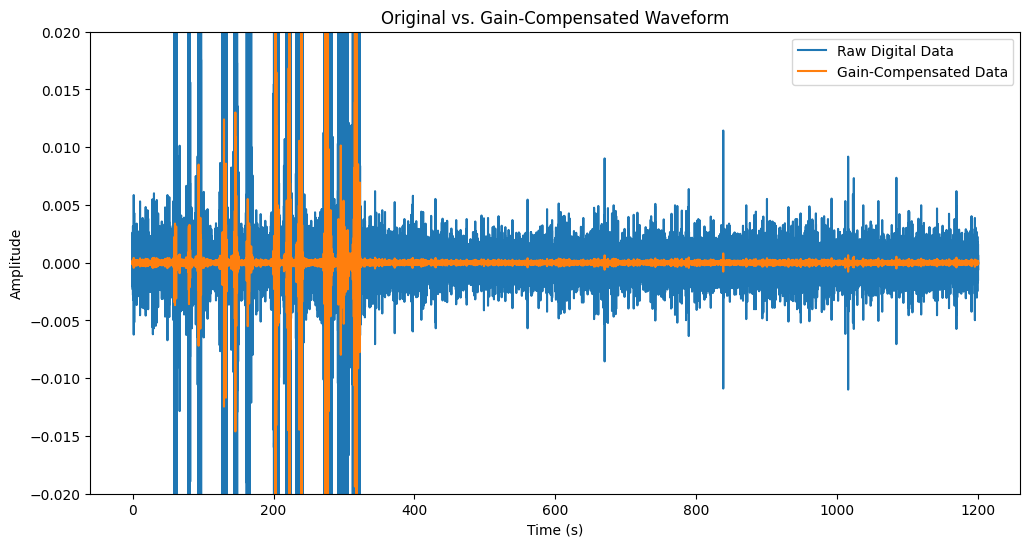

In [27]:
preamp_gain_db = 23  # preamp gain in dB for this recording
linear_gain = 10**(preamp_gain_db / 20)
calibrated_data = data / linear_gain

print(f"Sampling Rate: {samplerate} Hz")
print(f"Original data shape: {data.shape}")
print(f"Linear gain factor: {linear_gain:.2f}")

# plot the raw and calibrated waveforms for verification
time = np.arange(len(data)) / samplerate
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))
plt.plot(time, data, label="Raw Digital Data")
plt.plot(time, calibrated_data, label="Gain-Compensated Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs. Gain-Compensated Waveform")
plt.legend(loc='upper right')
plt.ylim(-0.02, 0.02)
# saving instead of showing to avoid space usage issues
#plt.savefig("calibration_plots/MRM2/test_waveform_comparison.png", dpi=300)
plt.show()

Spectrogram (for frequency high and low cut selection)

In [ ]:
# commenting this out because it takes so long to run
#frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)
#plt.figure(figsize=(15, 6))
#plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
#plt.colorbar(label='Intensity [dB]') 
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.title('Acoustic Signal Spectrogram')
#plt.ylim([0, samplerate / 2])  # limit y-axis to Nyquist frequency
#plt.savefig("calibration_plots/MRM2/test_spectrogram.png", dpi=300)
#plt.close()

Time averaged frequency spectrum 

In [ ]:
frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)

# average spectrum over time
cols = np.arange(len(times))
spec_avg = Sxx[:, cols].mean(axis=1)
spec_sm = gaussian_filter1d(spec_avg, 2) # smooth with gaussian filter; sigma=2

# plot the averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies, spec_sm, label="Smoothed avg spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: Averaged Spectrum")
plt.tight_layout()
plt.savefig("calibration_plots/MRM2/test_time_avg_spectrum.png", dpi=300)
plt.close()

FFT frequency spectrum

In [ ]:
# FFT-based frequency spectrum
fft_data = np.fft.fft(calibrated_data)
frequencies_fft = np.fft.fftfreq(len(calibrated_data), 1/samplerate)

# take only positive frequencies and convert to magnitude
positive_freq_mask = frequencies_fft >= 0
frequencies_fft = frequencies_fft[positive_freq_mask]
magnitude_spectrum = np.abs(fft_data[positive_freq_mask])
spec_sm_fft = gaussian_filter1d(magnitude_spectrum, 500)  # smooth with gaussian filter; sigma=500

# plot FFT-based averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies_fft, spec_sm_fft, label="Smoothed FFT spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: FFT-Based Spectrum")
plt.tight_layout()
plt.savefig("calibration_plots/MRM2/test_fft_spectrum.png", dpi=300)
plt.close()

Functions to select frequency band

In [18]:
def band_sos(low, high, fs, order=5):
    nyq = 0.5 * fs
    lown = max(low / nyq, 1e-6) # avoid 0 or negative
    highn = min(high / nyq, 0.999999) # avoid >1
    return butter(order, [lown := lown, highn], btype='band', output='sos') # bandpass filter

def apply_band_and_energy(x, fs, band, order=4):
    low, high = band 
    sos = band_sos(low, high, fs, order=order)
    y = sosfiltfilt(sos, x)
    # energy (RMS^2) overall and in sliding windows if desired
    energy = np.mean(y**2)
    return y, energy

def band_test_and_plot(x, fs, bands, event_window=None, quiet_window=None, nperseg=2048, noverlap=None):
    if noverlap is None:
        noverlap = nperseg // 2
    results = {}
    for band in bands:
        y, energy = apply_band_and_energy(x, fs, band)
        # compute spectrogram for plotting
        f, t, Sxx = spectrogram(y, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, scaling='density', mode='magnitude')
        results[band] = {'y': y, 'energy': energy, 'f': f, 't': t, 'Sxx': Sxx}

    # compute event and quiet band energies if windows provided
    if event_window is not None:
        t0, t1 = event_window
        idx0 = int(t0 * fs); idx1 = int(t1 * fs)
    else:
        idx0, idx1 = 0, len(x)
    if quiet_window is not None:
        q0, q1 = quiet_window
        qidx0, qidx1 = int(q0*fs), int(q1*fs)
    else:
        # pick a quiet stretch before the event if possible
        qidx0, qidx1 = 0, min(int(0.5*fs), len(x))

    print("Band energy summary (mean squared) and event/quiet ratios:")
    eps = np.finfo(float).eps # small number to avoid div by 0
    for band, info in results.items():
        y = info['y'] # band-passed signal
        event_energy = np.mean(y[idx0:idx1]**2) # average power during event
        quiet_energy = np.median(y[qidx0:qidx1]**2)     # robust noise estimate
        quiet_energy = max(quiet_energy, eps)           # avoid division by 0
        ratio = event_energy / quiet_energy
        snr_db = 10.0 * np.log10(ratio)
        print(f"{band[0]:4.0f}-{band[1]:4.0f} Hz:"
            f" total {info['energy']:.3e},"
            f" event_power {event_energy:.3e},"
            f" quiet_power {quiet_energy:.3e},"
            f" ratio {ratio:.2f}, snr={snr_db:.1f} dB")

    # plot spectrograms side-by-side for visual comparison
    n = len(bands)
    plt.figure(figsize=(12, 3*n))
    for i, band in enumerate(bands, start=1):
        info = results[band]
        plt.subplot(n, 1, i)
        plt.pcolormesh(info['t'], info['f'], 10*np.log10(info['Sxx'] + 1e-12), shading='auto')
        plt.ylim(0, min(3000, fs/2))
        plt.title(f"Band {band[0]}-{band[1]} Hz spectrogram")
        plt.ylabel("Freq (Hz)")
        plt.colorbar(label='dB')
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

    return results

In [ ]:
bands = [(20,300), (700,1500), (20,2000)]
results = band_test_and_plot(calibrated_data, samplerate, bands, event_window=(50,340), quiet_window=(340,1200))

Play filtered recordings for verification

In [ ]:
# play original
# normalize to avoid clipping
def play_array(x, fs, norm=True):
    xr = x / (np.max(np.abs(x)) + 1e-12) if norm else x
    display(Audio(xr, rate=fs))

play_array(calibrated_data, samplerate)

In [ ]:
# low band (20-200 Hz)
low = apply_band_and_energy(calibrated_data, samplerate, (20,200))[0] 
play_array(low, samplerate)

In [ ]:
# mid band (700-1500 Hz)
mid = apply_band_and_energy(calibrated_data, samplerate, (700,1500))[0]
play_array(mid, samplerate)

In [ ]:
# full band (20-2000 Hz)
full = apply_band_and_energy(calibrated_data, samplerate, (20,2000))[0]
play_array(full, samplerate)

### Band-Pass Filtering 

Filter Order Selection

In [19]:
def band_pass_filter(data, samplerate, low, high, order):
    nyquist = 0.5 * samplerate
    low = low / nyquist
    high = high / nyquist
    b, a = butter(order, [low, high], btype='band') # get filter coefficients
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [ ]:
# plotting the filters
lowcut = 700       # low cutoff frequency (Hz)
highcut = 1500       # high cutoff frequency (Hz)
orders = [3, 4, 5, 6]  # filter orders to compare
nyquist = 0.5 * samplerate
plt.figure(figsize=(7, 4))

for order in orders:
    # get the filter coefficients
    b, a = butter(order, [lowcut / nyquist, highcut / nyquist], btype='band')
    # calculate the frequency response
    w, h = freqz(b, a, worN=2000) # worN determines the number of points at which to evaluate the response

    # convert angular frequency to Hz and magnitude to a linear scale (0-1)
    frequencies = w * samplerate / (2 * np.pi)
    magnitude_response = np.abs(h)

    # plot the magnitude response
    plt.plot(frequencies, magnitude_response, label=f'Order {order}')

# add vertical line at cutoff frequencies
plt.axvline(lowcut, color='gray', linestyle='--', label='Low Cutoff')
plt.axvline(highcut, color='gray', linestyle='--', label='High Cutoff')
plt.title('Butterworth Band-Pass Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.xlim(0, 3000)  # Adjust x-axis limits to better visualize the passband
plt.ylim(0, 1.1)   # Adjust y-axis limits
plt.savefig("calibration_plots/MRM2/test_bandpass_filter.png", dpi=300)
plt.close()

In [ ]:
lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

data_3 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=3)
data_4 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
data_5 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=5)

# visualize the filtered signal
plt.figure(figsize=(12, 6))
plt.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)
plt.plot(time, data_3, label="Order 3", color='blue', alpha=0.5)
plt.plot(time, data_4, label="Order 4", color='green', alpha=0.5)
plt.plot(time, data_5, label="Order 5", color='red', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
plt.legend(loc='upper right')
plt.savefig("calibration_plots/MRM2/test_bandpass_filtered_signal.png", dpi=300)
plt.close()

Subsample for noise detection

In [ ]:
# individual impact - between 55 and 65 seconds
subsample = calibrated_data[int(55 * samplerate):int(65 * samplerate)]
sub3 = data_3[int(55 * samplerate):int(65 * samplerate)]
sub5 = data_5[int(55 * samplerate):int(65 * samplerate)]
subtime = np.arange(len(subsample)) / samplerate

In [ ]:
# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(subtime, subsample, label="Original", color='orange', alpha=0.7)
plt.plot(subtime, sub5, label="Order 5", color='red', alpha=0.6)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
plt.ylim(-0.01, 0.01)
plt.legend(loc='upper right')
plt.savefig("calibration_plots/MRM2/test_subsample_bandpass_filtered_signal.png", dpi=300)
plt.close()

Filter Data and Amplify

In [20]:
lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

# first band-pass filter the entire calibrated data
filtered_data1 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
filtered_data2 = filtered_data1 * 20

# second band-pass filter
filtered_data3 = band_pass_filter(filtered_data2, samplerate, lowcut, highcut, order=4)
filtered_data = filtered_data3 * 10

In [ ]:
# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(time, filtered_data2, label="Filtered (1st)", color='red', alpha=0.7)
plt.plot(time, filtered_data3, label="Filtered (2nd)", color='blue', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signals (Without Amplification)")
plt.legend(loc='upper right')
twin = plt.twinx()
twin.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)

#plt.xlim(41.2, 42)  # zoom in to see details
plt.savefig("calibration_plots/MRM2/test_bandpass_filtered_signals_full.png", dpi=300)
plt.close()

In [ ]:
# DELETING VARIABLES NOT NEEDED ANYMORE
del data, calibrated_data, data_3, data_4, data_5
del sub3, sub5, h, cols, fft_data, frequencies_fft, 
del magnitude_spectrum, spec_sm_fft, full, positive_freq_mask
del filtered_data1, filtered_data2, filtered_data3, lowcut, highcut
del orders, b, a, w, frequencies, times
del twin, spec_sm, spec_avg, magnitude_response, results, input_flac_file

### Envelope Detection

Subsample for envelope

In [ ]:
subsample = filtered_data[int(58.3 * samplerate):int(62.5 * samplerate)]
subtime = np.arange(len(subsample)) / samplerate

# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(subtime, subsample, label="Filtered", color='orange', alpha=0.5)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
#plt.ylim(-0.1, 0.1)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# using the hilbert transform 
analytic_signal = hilbert(subsample)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 300 # # low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(subsample))

# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(subtime, subsample, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(subtime, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(subtime, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope: Zoomed in subsample")
plt.legend()
plt.xlim(1.07, 1.18)
plt.savefig("calibration_plots/MRM2/test_signal_envelopes_zoomed_single.png", dpi=300)
plt.show()

Full Sample

In [22]:
# using the hilbert transform 
nyquist = 0.5 * samplerate
analytic_signal = hilbert(filtered_data)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 100 # # low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(filtered_data))

In [ ]:
# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, filtered_data, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(time, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope")
plt.legend(loc='upper right')
#plt.xlim(42.4, 42.7)
#plt.ylim(-5, 5)
plt.savefig("calibration_plots/MRM2/test_signal_envelopes_full.png", dpi=300)
plt.show()

### Pulse counting and Rectangular waveform

Compute and plot the rectangular waveforms

In [23]:
# channel gains (relative multipliers) from 
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

# voltage thresholds for impulse detection
lower_thresh = 2  # volts

# first column of results is the time index of detected impulses
rect_hilbert = pd.DataFrame({'time': time})
rect_rectified = pd.DataFrame({'time': time})

# loop over channels, apply gain, and detect impulses
# for hilbert envelope
for ch, gain in gains.items():
    amplified = envelope_hilbert * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_hilbert[f'ch{ch}'] = rectangular

# for rectified envelope
for ch, gain in gains.items():
    amplified = envelope_rectified * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_rectified[f'ch{ch}'] = rectangular

del amplified, binary, rectangular, ch, gain

In [ ]:
# visualize rect waveforms from hilbert envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000  

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_hilbert['time'][::downsample_factor]
    downsampled_signal = rect_hilbert[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Hilbert Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/MRM2/test_rect_from_hilbert_subplots.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# visualize rect waveforms from rectified envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000 

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_rectified['time'][::downsample_factor]
    downsampled_signal = rect_rectified[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Rectified Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/MRM2/test_rect_from_rectified_subplots.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, envelope_hilbert*64, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, rect_hilbert['ch3'], 'r-', linewidth=2, label='Rectangular Waveform')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (V)")
plt.title("Hilbert Envelope and Rectangular Waveform (Ch3 - Gain x64)")
plt.legend(loc='upper right')
plt.xlim(59.32, 59.45)
plt.ylim(-1, 27)
plt.savefig("calibration_plots/MRM1/test_signal_envelopes_sub.png", dpi=300)
plt.show()

Counting pulses by particle impact

In [24]:
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

fs = samplerate  # sampling frequency (Hz)
dt = 1.0         # target bin size in seconds

# build bins
time_bins = np.arange(time[0], time[-1] + dt, dt)
time_index = pd.to_timedelta(time_bins[:-1], unit="s")

# function to count impulses (rising edges) per second
def count_impulses(rect_signal, fs):
    # detect rising edges: 0→5 transitions
    rising_edges = np.diff((rect_signal > 0).astype(int)) == 1
    edge_times = time[1:][rising_edges]
    # bin counts into 1s intervals
    counts, _ = np.histogram(edge_times, bins=time_bins)
    return counts

# prepare output containers
results_hilbert = pd.DataFrame(index=time_index)
results_rectified = pd.DataFrame(index=time_index)
df_env = pd.DataFrame(index=pd.to_timedelta(time, unit="s"))

# 1) count impulses
for ch, gain in gains.items():
    impulses = count_impulses(rect_hilbert[f"ch{ch}"].values, fs)
    results_hilbert[f"impulses_ch{ch}"] = impulses

    impulses = count_impulses(rect_rectified[f"ch{ch}"].values, fs)
    results_rectified[f"impulses_ch{ch}"] = impulses
    # per-channel rect (0–5 V pulse train)
    df_env[f"hil_rect_ch{ch}"] = rect_hilbert[f"ch{ch}"]
    df_env[f"rect_rect_ch{ch}"] = rect_rectified[f"ch{ch}"]
    # per-channel envelope (apply gain to original envelopes)
    df_env[f"hil_env_ch{ch}"] = envelope_hilbert * gain
    df_env[f"rect_env_ch{ch}"] = envelope_rectified * gain

# 2) average envelope amplitude at 1 Hz
# put both hilbert + rectified envelopes into one structure
df_env_combined = pd.DataFrame({
    "time": time,
    "hilbert": envelope_hilbert,
    "rectified": envelope_rectified
})

# resample to 1 Hz (average every second)
df_env_combined.index = pd.to_timedelta(df_env_combined["time"], unit="s")
df_env_1hz = df_env_combined.resample("1s").mean()

# final result: combine counts + averages
final_hilbert = results_hilbert.join(df_env_1hz["hilbert"])
final_rectified = results_rectified.join(df_env_1hz["rectified"])

### Separate impacts by particle ID 

In [25]:
samples = pd.read_csv('ManualRockMovements-2/mov2_pipe_particles.csv')  

For Hilbert Envelope

In [26]:
# add rectangular waveforms to final_hilbert
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_hilbert index
    rect_series = pd.Series(rect_hilbert[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_hilbert * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"env_ch{ch}"] = env_series.resample("1s").mean()

results = []

for _, row in samples.iterrows():
    sid = row["id"]
    t0 = row["start_time"]
    t1 = row["end_time"]

    # slice the dataframe by timedelta index
    window = final_hilbert.loc[pd.to_timedelta(t0, unit="s") : pd.to_timedelta(t1, unit="s")]

    # sum impulses per channel
    impulse_sums = window.filter(like="impulses_ch").sum()

    # amplitude stats (full envelope during window)
    max_amp = window["hilbert"].max()
    mean_amp = window["hilbert"].mean()
    median_amp = window["hilbert"].median()

    # collect everything
    result = {
        "SampleID": sid,
        "t0": t0,
        "t1": t1,
        "max_amp": max_amp,
        "mean_amp": mean_amp,
        "median_amp": median_amp,
    }
    result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses
    for ch in gains.keys():
        rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
        env_col  = f"env_ch{ch}"       # envelope for this channel

        # slice rect + envelope in same time window
        rect_sig = final_hilbert[f"rect_ch{ch}"].loc[window.index]
        env_sig  = final_hilbert[f"env_ch{ch}"].loc[window.index]

        # take only times when impulse (rect = 5V)
        mask = rect_sig > 0 # impulses
        if mask.any():
            result[f"ch{ch}_max"]   = env_sig[mask].max()
            result[f"ch{ch}_mean"]   = env_sig[mask].mean()
            result[f"ch{ch}_median"] = env_sig[mask].median()
        else:
            result[f"ch{ch}_max"]   = np.nan
            result[f"ch{ch}_mean"]   = np.nan
            result[f"ch{ch}_median"] = np.nan

    results.append(result)

df_results = pd.DataFrame(results)
df_results.to_csv("ManualRockMovements-2/impact_results_hilbert.csv", index=False)

For Rectified Envelope

In [27]:
# add rectangular waveforms to final_rectifies
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_rectified index
    rect_series = pd.Series(rect_rectified[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_rectified * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"env_ch{ch}"] = env_series.resample("1s").mean()

results = []

for _, row in samples.iterrows():
    sid = row["id"]
    t0 = row["start_time"]
    t1 = row["end_time"]

    # slice the dataframe by timedelta index
    window = final_rectified.loc[pd.to_timedelta(t0, unit="s") : pd.to_timedelta(t1, unit="s")]

    # sum impulses per channel
    impulse_sums = window.filter(like="impulses_ch").sum()

    # amplitude stats (full envelope during window)
    max_amp = window["rectified"].max()
    mean_amp = window["rectified"].mean()
    median_amp = window["rectified"].median()

    # collect everything
    result = {
        "SampleID": sid,
        "t0": t0,
        "t1": t1,
        "max_amp": max_amp,
        "mean_amp": mean_amp,
        "median_amp": median_amp,
    }
    result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses
    for ch in gains.keys():
        rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
        env_col  = f"env_ch{ch}"       # envelope for this channel

        # slice rect + envelope in same time window
        rect_sig = final_rectified[f"rect_ch{ch}"].loc[window.index]
        env_sig  = final_rectified[f"env_ch{ch}"].loc[window.index]

        # take only times when impulse (rect = 5V)
        mask = rect_sig > 0 # impulses
        if mask.any():
            result[f"ch{ch}_max"]   = env_sig[mask].max()
            result[f"ch{ch}_mean"]   = env_sig[mask].mean()
            result[f"ch{ch}_median"] = env_sig[mask].median()
        else:
            result[f"ch{ch}_max"]   = np.nan
            result[f"ch{ch}_mean"]   = np.nan
            result[f"ch{ch}_median"] = np.nan

    results.append(result)

df_results = pd.DataFrame(results)
df_results.to_csv("ManualRockMovements-2/impact_results_rectified.csv", index=False)

In [28]:
# delete all variables to start new section
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

# Flood Experiments

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import soundfile as sf
from scipy.signal import butter, filtfilt, hilbert, spectrogram, freqz, sosfiltfilt, find_peaks, sosfilt
from scipy.ndimage import gaussian_filter1d
from IPython.display import Audio, display

## Flood 1

In [30]:
input_flac_file = "EXP-09-20-23-FLOW1/audio/Nicole_091823-000100.flac"
data, samplerate = sf.read(input_flac_file)

# pipe is left channel 
if data.ndim > 1:
    data = data[:,0] # keep the left channel, which in this case is the impact pipe

Gain Compensation

In [31]:
# for some reason there was a lot of static in the recordings, don't know if it was like a hardware thing? 
preamp_gain_db = 23  # preamp gain in dB for this recording
linear_gain = 10**(preamp_gain_db / 20)
calibrated_data = data / linear_gain

print(f"Sampling Rate: {samplerate} Hz")
print(f"Original data shape: {data.shape}")
print(f"Linear gain factor: {linear_gain:.2f}")

# plot the raw and calibrated waveforms for verification
time = np.arange(len(data)) / samplerate
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))
plt.plot(time, data, label="Raw Digital Data")
plt.plot(time, calibrated_data, label="Gain-Compensated Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs. Gain-Compensated Waveform")
plt.legend(loc='upper right')
# saving instead of showing to avoid space usage issues
plt.savefig("calibration_plots/floods/f1/f1_waveform_comparison.png", dpi=300)
plt.close()

Sampling Rate: 44100 Hz
Original data shape: (52920000,)
Linear gain factor: 14.13


In [ ]:
# commenting this out because it takes so long to run
#frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)
#plt.figure(figsize=(15, 6))
#plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
#plt.colorbar(label='Intensity [dB]') 
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.title('Acoustic Signal Spectrogram')
#plt.ylim([0, samplerate / 2])  # limit y-axis to Nyquist frequency
#plt.savefig("calibration_plots/floods/f1/f1_spectrogram.png", dpi=300)
#plt.close()
# takes like 15 mins on my laptop

Time averaged frequency spectrum

In [ ]:
frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)

# average spectrum over time
cols = np.arange(len(times))
spec_avg = Sxx[:, cols].mean(axis=1)
spec_sm = gaussian_filter1d(spec_avg, 2) # smooth with gaussian filter; sigma=2

# plot the averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies, spec_sm, label="Smoothed avg spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: Averaged Spectrum")
plt.tight_layout()
plt.savefig("calibration_plots/floods/f1/f1_time_avg_spectrum.png", dpi=300)
plt.close()

Functions to select frequency band

In [32]:
def band_sos(low, high, fs, order=5):
    nyq = 0.5 * fs
    lown = max(low / nyq, 1e-6) # avoid 0 or negative
    highn = min(high / nyq, 0.999999) # avoid >1
    return butter(order, [lown := lown, highn], btype='band', output='sos') # bandpass filter

def apply_band_and_energy(x, fs, band, order=4):
    low, high = band 
    sos = band_sos(low, high, fs, order=order)
    y = sosfiltfilt(sos, x)
    # energy (RMS^2) overall and in sliding windows if desired
    energy = np.mean(y**2)
    return y, energy

def band_test_and_plot(x, fs, bands, event_window=None, quiet_window=None, nperseg=2048, noverlap=None):
    if noverlap is None:
        noverlap = nperseg // 2
    results = {}
    for band in bands:
        y, energy = apply_band_and_energy(x, fs, band)
        # compute spectrogram for plotting
        f, t, Sxx = spectrogram(y, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap, scaling='density', mode='magnitude')
        results[band] = {'y': y, 'energy': energy, 'f': f, 't': t, 'Sxx': Sxx}

    # compute event and quiet band energies if windows provided
    if event_window is not None:
        t0, t1 = event_window
        idx0 = int(t0 * fs); idx1 = int(t1 * fs)
    else:
        idx0, idx1 = 0, len(x)
    if quiet_window is not None:
        q0, q1 = quiet_window
        qidx0, qidx1 = int(q0*fs), int(q1*fs)
    else:
        # pick a quiet stretch before the event if possible
        qidx0, qidx1 = 0, min(int(0.5*fs), len(x))

    print("Band energy summary (mean squared) and event/quiet ratios:")
    eps = np.finfo(float).eps # small number to avoid div by 0
    for band, info in results.items():
        y = info['y'] # band-passed signal
        event_energy = np.mean(y[idx0:idx1]**2) # average power during event
        quiet_energy = np.median(y[qidx0:qidx1]**2)     # robust noise estimate
        quiet_energy = max(quiet_energy, eps)           # avoid division by 0
        ratio = event_energy / quiet_energy
        snr_db = 10.0 * np.log10(ratio)
        print(f"{band[0]:4.0f}-{band[1]:4.0f} Hz:"
            f" total {info['energy']:.3e},"
            f" event_power {event_energy:.3e},"
            f" quiet_power {quiet_energy:.3e},"
            f" ratio {ratio:.2f}, snr={snr_db:.1f} dB")

    # plot spectrograms side-by-side for visual comparison
    n = len(bands)
    plt.figure(figsize=(12, 3*n))
    for i, band in enumerate(bands, start=1):
        info = results[band]
        plt.subplot(n, 1, i)
        plt.pcolormesh(info['t'], info['f'], 10*np.log10(info['Sxx'] + 1e-12), shading='auto')
        plt.ylim(0, min(3000, fs/2))
        plt.title(f"Band {band[0]}-{band[1]} Hz spectrogram")
        plt.ylabel("Freq (Hz)")
        plt.colorbar(label='dB')
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

    return results

In [ ]:
bands = [(20,300), (700,1500), (20,2000)]
results = band_test_and_plot(calibrated_data, samplerate, bands, event_window=(0,600), quiet_window=(600,1200))

Play filtered recordings for verification

In [ ]:
# play original
# normalize to avoid clipping
def play_array(x, fs, norm=True):
    xr = x / (np.max(np.abs(x)) + 1e-12) if norm else x
    display(Audio(xr, rate=fs))

play_array(calibrated_data, samplerate)

In [ ]:
# low band (20-200 Hz)
low = apply_band_and_energy(calibrated_data, samplerate, (20,200))[0] 
play_array(low, samplerate)

In [ ]:
# mid band (700-1500 Hz)
mid = apply_band_and_energy(calibrated_data, samplerate, (700,1500))[0]
play_array(mid, samplerate)

In [ ]:
# full band (20-2000 Hz)
full = apply_band_and_energy(calibrated_data, samplerate, (20,2000))[0]
play_array(full, samplerate)

### Band-Pass Filtering

In [33]:
def band_pass_filter(data, samplerate, low, high, order):
    nyquist = 0.5 * samplerate
    low = low / nyquist
    high = high / nyquist
    b, a = butter(order, [low, high], btype='band') # get filter coefficients
    filtered_data = filtfilt(b, a, data)
    return filtered_data

Select active sediment transport times

In [34]:
# only keep times between 180 to 660 seconds
calibrated_data = calibrated_data[180*samplerate:660*samplerate]
time = np.arange(len(calibrated_data)) / samplerate

# Debug prints
print(f"Sample rate: {samplerate}")
print(f"Data length after slicing: {len(calibrated_data)}")
print(f"Expected duration: {(660-180)} seconds")
print(f"Actual duration: {len(calibrated_data)/samplerate} seconds")
print(f"Time array min: {time.min()}, max: {time.max()}")

lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

data_3 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=3)
data_4 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
data_5 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=5)

# visualize the filtered signal
plt.figure(figsize=(12, 6))
plt.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)
plt.plot(time, data_3, label="Order 3", color='blue', alpha=0.5)
plt.plot(time, data_4, label="Order 4", color='green', alpha=0.5)
plt.plot(time, data_5, label="Order 5", color='red', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
plt.legend(loc='upper right')
plt.savefig("calibration_plots/floods/f1/f1_bandpass_filtered_signal.png", dpi=300)
plt.close()

Sample rate: 44100
Data length after slicing: 21168000
Expected duration: 480 seconds
Actual duration: 480.0 seconds
Time array min: 0.0, max: 479.99997732426306


Filter Data and Amplify

In [35]:
lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

# first band-pass filter the entire calibrated data
filtered_data1 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
filtered_data2 = filtered_data1 * 20

# second band-pass filter
filtered_data3 = band_pass_filter(filtered_data2, samplerate, lowcut, highcut, order=4)
filtered_data = filtered_data3 * 10

In [36]:
# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(time, filtered_data2, label="Filtered (1st)", color='red', alpha=0.7)
plt.plot(time, filtered_data3, label="Filtered (2nd)", color='blue', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signals (Without Amplification)")
plt.legend(loc='upper right')
twin = plt.twinx()
twin.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)

#plt.xlim(41.9, 42)  # zoom in to see details
plt.savefig("calibration_plots/floods/f1/f1_bandpass_filtered_signals_full.png", dpi=300)
plt.close()

### Envelope Detection

In [37]:
# using the hilbert transform 
nyquist = 0.5 * samplerate
analytic_signal = hilbert(filtered_data)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 100 # # low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(filtered_data))

In [ ]:
# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, filtered_data, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(time, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope")
plt.legend(loc='upper right')
#plt.xlim(42.4, 42.7)
#plt.ylim(-5, 5)
plt.savefig("calibration_plots/floods/f1/f1_signal_envelopes_full.png", dpi=300)
plt.show()

Pulse counting and Rectangular waveform

In [38]:
# channel gains (relative multipliers) from 
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

# voltage thresholds for impulse detection
lower_thresh = 2  # volts

# first column of results is the time index of detected impulses
rect_hilbert = pd.DataFrame({'time': time})
rect_rectified = pd.DataFrame({'time': time})

# loop over channels, apply gain, and detect impulses
# for hilbert envelope
for ch, gain in gains.items():
    amplified = envelope_hilbert * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_hilbert[f'ch{ch}'] = rectangular

# for rectified envelope
for ch, gain in gains.items():
    amplified = envelope_rectified * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_rectified[f'ch{ch}'] = rectangular

del amplified, binary, rectangular, ch, gain

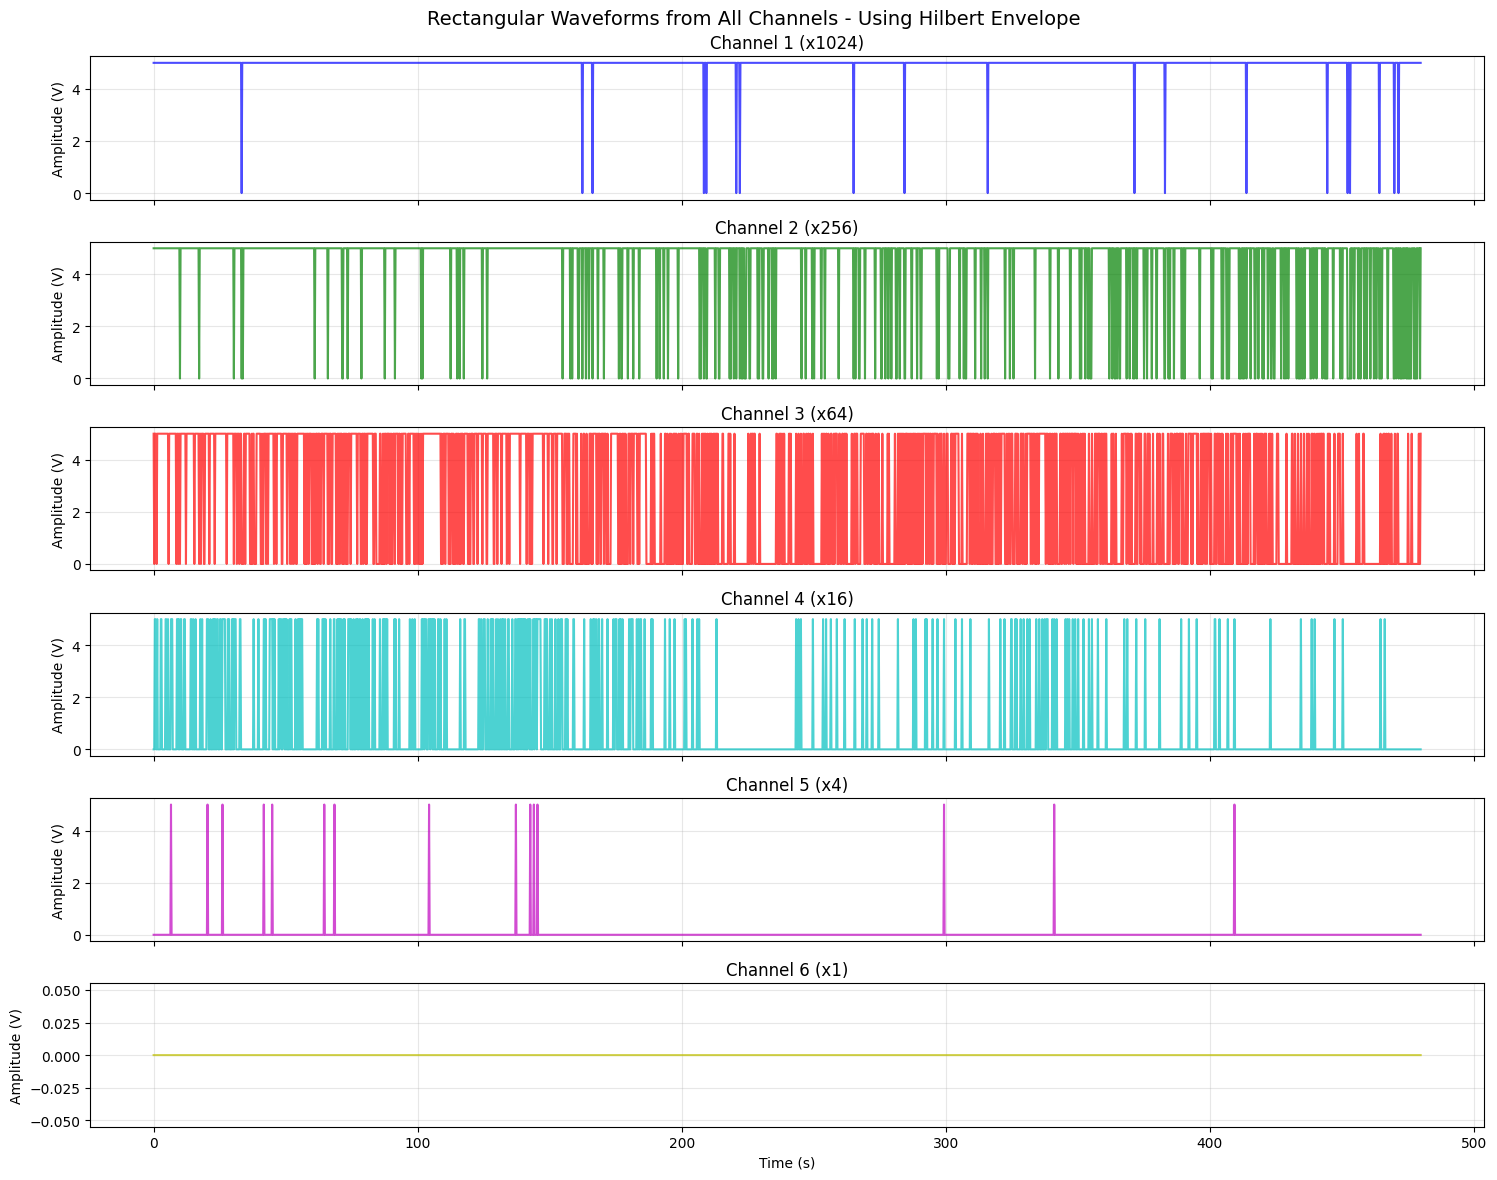

In [39]:
# visualize rect waveforms from hilbert envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000  

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_hilbert['time'][::downsample_factor]
    downsampled_signal = rect_hilbert[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Hilbert Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/floods/f1/f1_rect_from_hilbert.png", dpi=300, bbox_inches='tight')
plt.show()

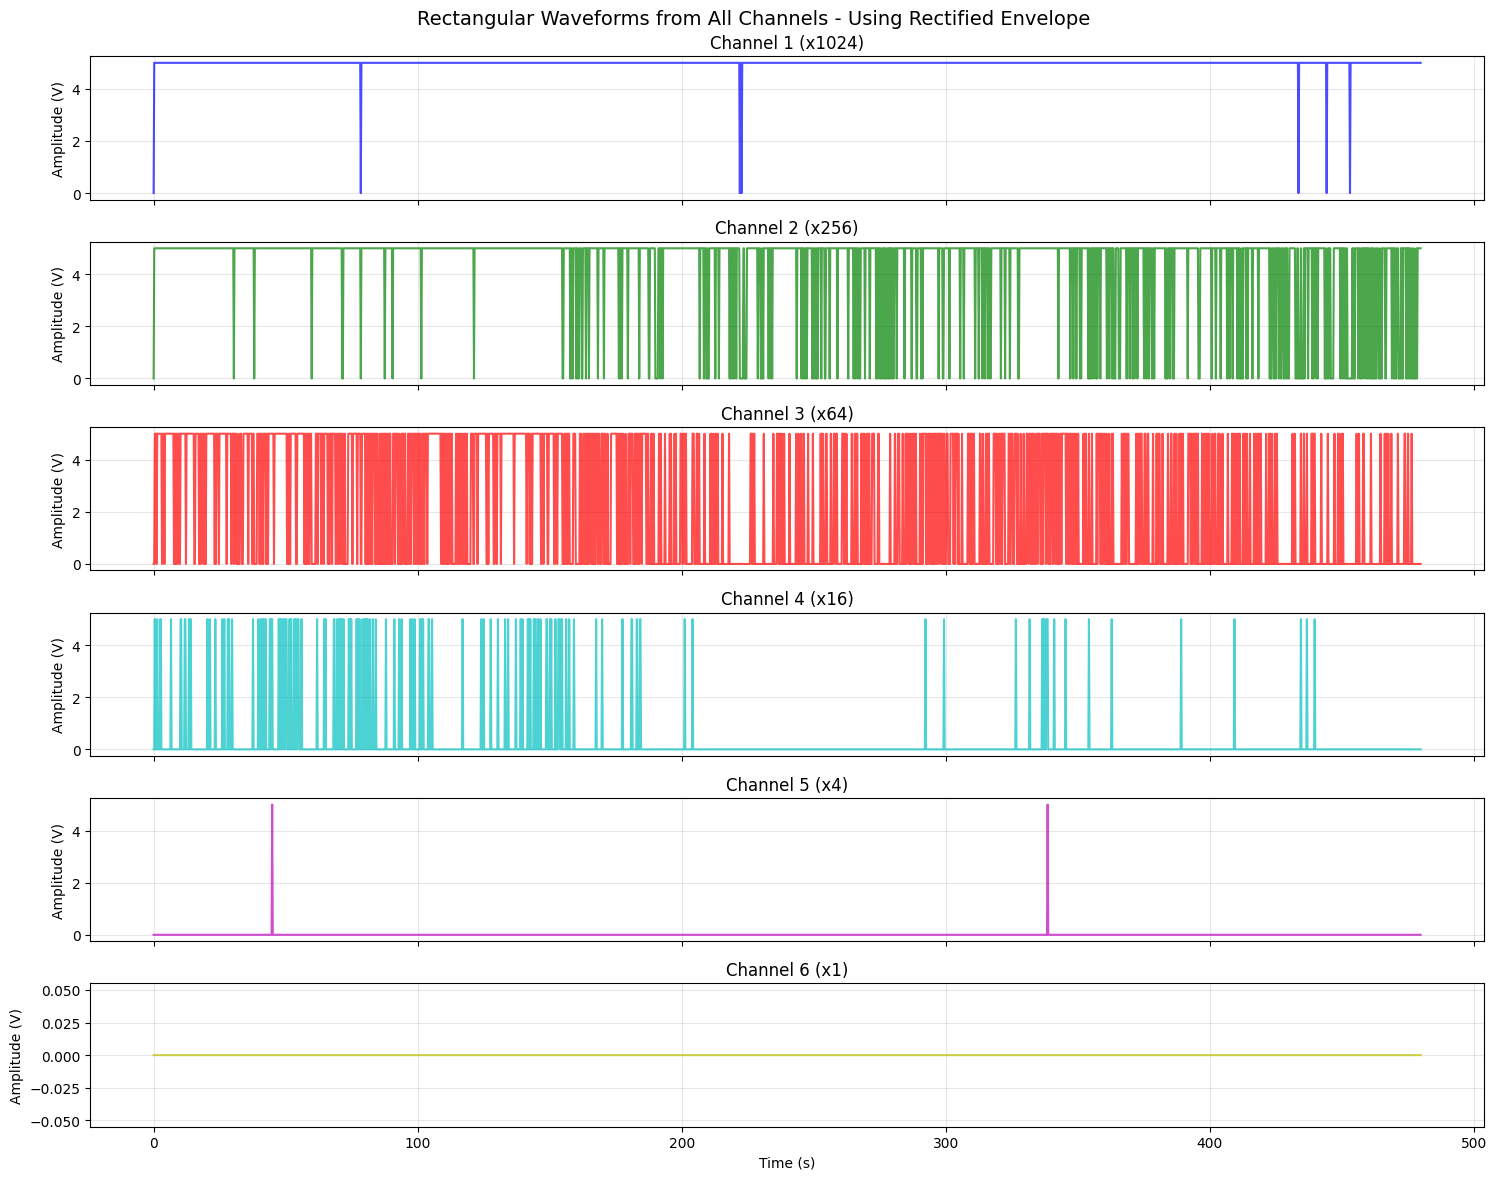

In [40]:
# visualize rect waveforms from rectified envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000 

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_rectified['time'][::downsample_factor]
    downsampled_signal = rect_rectified[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Rectified Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/floods/f1/f1_rect_from_rectified.png", dpi=300, bbox_inches='tight')
plt.show()

Counting pulses by particle impact

In [41]:
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

fs = samplerate  # sampling frequency (Hz)
dt = 1.0         # target bin size in seconds

# build bins
time_bins = np.arange(time[0], time[-1] + dt, dt)
time_index = pd.to_timedelta(time_bins[:-1], unit="s")

# function to count impulses (rising edges) per second
def count_impulses(rect_signal, fs):
    # detect rising edges: 0→5 transitions
    rising_edges = np.diff((rect_signal > 0).astype(int)) == 1
    edge_times = time[1:][rising_edges]
    # bin counts into 1s intervals
    counts, _ = np.histogram(edge_times, bins=time_bins)
    return counts

# prepare output containers
results_hilbert = pd.DataFrame(index=time_index)
results_rectified = pd.DataFrame(index=time_index)
df_env = pd.DataFrame(index=pd.to_timedelta(time, unit="s"))

# 1) count impulses
for ch, gain in gains.items():
    impulses = count_impulses(rect_hilbert[f"ch{ch}"].values, fs)
    results_hilbert[f"impulses_ch{ch}"] = impulses

    impulses = count_impulses(rect_rectified[f"ch{ch}"].values, fs)
    results_rectified[f"impulses_ch{ch}"] = impulses
    # per-channel rect (0–5 V pulse train)
    df_env[f"hil_rect_ch{ch}"] = rect_hilbert[f"ch{ch}"]
    df_env[f"rect_rect_ch{ch}"] = rect_rectified[f"ch{ch}"]
    # per-channel envelope (apply gain to original envelopes)
    df_env[f"hil_env_ch{ch}"] = envelope_hilbert * gain
    df_env[f"rect_env_ch{ch}"] = envelope_rectified * gain

# 2) average envelope amplitude at 1 Hz
# put both hilbert + rectified envelopes into one structure
df_env_combined = pd.DataFrame({
    "time": time,
    "hilbert": envelope_hilbert,
    "rectified": envelope_rectified
})

# resample to 1 Hz (average every second)
df_env_combined.index = pd.to_timedelta(df_env_combined["time"], unit="s")
df_env_1hz = df_env_combined.resample("1s").mean()

# final result: combine counts + averages
final_hilbert = results_hilbert.join(df_env_1hz["hilbert"])
final_rectified = results_rectified.join(df_env_1hz["rectified"])

### Separate average amp over impulse times

For Hilber Envelope by Channel 

In [42]:
# add rectangular waveforms to final_hilbert
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_hilbert index
    rect_series = pd.Series(rect_hilbert[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_hilbert * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"env_ch{ch}"] = env_series.resample("1s").mean()

# analyze the entire sampling period as one window
t0 = time.min()  # start of entire period
t1 = time.max()  # end of entire period (should be ~480s)

# use the entire final_hilbert dataframe as the window
window = final_hilbert

# sum impulses per channel over entire period
impulse_sums = window.filter(like="impulses_ch").sum()

# amplitude stats (full envelope during entire period)
max_amp = window["hilbert"].max()
mean_amp = window["hilbert"].mean()
median_amp = window["hilbert"].median()

# collect everything
result = {
    "SampleID": "flood1",  # or whatever identifier you want
    "t0": t0,
    "t1": t1,
    "max_amp": max_amp,
    "mean_amp": mean_amp,
    "median_amp": median_amp,
}
result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses for entire period
for ch in gains.keys():
    rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
    env_col  = f"env_ch{ch}"       # envelope for this channel

    # get rect + envelope for entire period
    rect_sig = final_hilbert[f"rect_ch{ch}"]
    env_sig  = final_hilbert[f"env_ch{ch}"]

    # take only times when impulse (rect = 5V)
    mask = rect_sig > 0 # impulses
    if mask.any():
        result[f"ch{ch}_max"]   = env_sig[mask].max()
        result[f"ch{ch}_mean"]   = env_sig[mask].mean()
        result[f"ch{ch}_median"] = env_sig[mask].median()
    else:
        result[f"ch{ch}_max"]   = np.nan
        result[f"ch{ch}_mean"]   = np.nan
        result[f"ch{ch}_median"] = np.nan

# create single-row dataframe
df_results = pd.DataFrame([result])
df_results.to_csv("EXP-09-20-23-FLOW1/f1_results_hilbert.csv", index=False)

For Rectified Envelope by Channel

In [43]:
# add rectangular waveforms to final_rectified
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_rectified index
    rect_series = pd.Series(rect_rectified[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_rectified * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"env_ch{ch}"] = env_series.resample("1s").mean()

# analyze the entire sampling period as one window
t0 = time.min()  # start of entire period
t1 = time.max()  # end of entire period (should be ~480s)

# use the entire final_rectified dataframe as the window
window = final_rectified

# sum impulses per channel over entire period
impulse_sums = window.filter(like="impulses_ch").sum()

# amplitude stats (full envelope during entire period)
max_amp = window["rectified"].max()
mean_amp = window["rectified"].mean()
median_amp = window["rectified"].median()

# collect everything
result = {
    "SampleID": "flood1",  # or whatever identifier you want
    "t0": t0,
    "t1": t1,
    "max_amp": max_amp,
    "mean_amp": mean_amp,
    "median_amp": median_amp,
}
result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses for entire period
for ch in gains.keys():
    rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
    env_col  = f"env_ch{ch}"       # envelope for this channel

    # get rect + envelope for entire period
    rect_sig = final_rectified[f"rect_ch{ch}"]
    env_sig  = final_rectified[f"env_ch{ch}"]

    # take only times when impulse (rect = 5V)
    mask = rect_sig > 0 # impulses
    if mask.any():
        result[f"ch{ch}_max"]   = env_sig[mask].max()
        result[f"ch{ch}_mean"]   = env_sig[mask].mean()
        result[f"ch{ch}_median"] = env_sig[mask].median()
    else:
        result[f"ch{ch}_max"]   = np.nan
        result[f"ch{ch}_mean"]   = np.nan
        result[f"ch{ch}_median"] = np.nan

# create single-row dataframe
df_results = pd.DataFrame([result])
df_results.to_csv("EXP-09-20-23-FLOW1/f1_results_rectified.csv", index=False)

## Flood 2

In [44]:
input_flac_file = 'EXP-09-20-23-FLOW2/audio/Nicole_091823-000100.flac'
data, samplerate = sf.read(input_flac_file)

# pipe is left channel 
if data.ndim > 1:
    data = data[:,0] # keep the left channel, which in this case is the impact pipe

Gain Compensation

In [45]:
# for some reason there was a lot of static in the recordings, don't know if it was like a hardware thing? 
preamp_gain_db = 23  # preamp gain in dB for this recording
linear_gain = 10**(preamp_gain_db / 20)
calibrated_data = data / linear_gain

print(f"Sampling Rate: {samplerate} Hz")
print(f"Original data shape: {data.shape}")
print(f"Linear gain factor: {linear_gain:.2f}")

# plot the raw and calibrated waveforms for verification
time = np.arange(len(data)) / samplerate
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))
plt.plot(time, data, label="Raw Digital Data")
plt.plot(time, calibrated_data, label="Gain-Compensated Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs. Gain-Compensated Waveform")
plt.legend(loc='upper right')
# saving instead of showing to avoid space usage issues
plt.savefig("calibration_plots/floods/f2/f2_waveform_comparison.png", dpi=300)
plt.close()

Sampling Rate: 44100 Hz
Original data shape: (52920000,)
Linear gain factor: 14.13


In [46]:
# commenting this out because it takes so long to run
#frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)
#plt.figure(figsize=(15, 6))
#plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
#plt.colorbar(label='Intensity [dB]') 
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.title('Acoustic Signal Spectrogram')
#plt.ylim([0, samplerate / 2])  # limit y-axis to Nyquist frequency
#plt.savefig("calibration_plots/floods/f2/f2_spectrogram.png", dpi=300)
#plt.close()
# takes like 15 mins on my laptop

In [47]:
frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)

# average spectrum over time
cols = np.arange(len(times))
spec_avg = Sxx[:, cols].mean(axis=1)
spec_sm = gaussian_filter1d(spec_avg, 2) # smooth with gaussian filter; sigma=2

# plot the averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies, spec_sm, label="Smoothed avg spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: Averaged Spectrum")
plt.tight_layout()
plt.savefig("calibration_plots/floods/f2/f2_time_avg_spectrum.png", dpi=300)
plt.close()

### Band-Pass Filtering

In [48]:
def band_pass_filter(data, samplerate, low, high, order):
    nyquist = 0.5 * samplerate
    low = low / nyquist
    high = high / nyquist
    b, a = butter(order, [low, high], btype='band') # get filter coefficients
    filtered_data = filtfilt(b, a, data)
    return filtered_data

Select active sediment transport times

In [49]:
# only keep times between 200 to 250 seconds
calibrated_data = calibrated_data[200*samplerate:250*samplerate]
time = np.arange(len(calibrated_data)) / samplerate

# Debug prints
print(f"Sample rate: {samplerate}")
print(f"Data length after slicing: {len(calibrated_data)}")
print(f"Expected duration: {(660-180)} seconds")
print(f"Actual duration: {len(calibrated_data)/samplerate} seconds")
print(f"Time array min: {time.min()}, max: {time.max()}")

lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

data_3 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=3)
data_4 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
data_5 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=5)

# visualize the filtered signal
plt.figure(figsize=(12, 6))
plt.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)
plt.plot(time, data_3, label="Order 3", color='blue', alpha=0.5)
plt.plot(time, data_4, label="Order 4", color='green', alpha=0.5)
plt.plot(time, data_5, label="Order 5", color='red', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signal")
plt.legend(loc='upper right')
plt.savefig("calibration_plots/floods/f2/f2_bandpass_filtered_signal.png", dpi=300)
plt.close()

Sample rate: 44100
Data length after slicing: 2205000
Expected duration: 480 seconds
Actual duration: 50.0 seconds
Time array min: 0.0, max: 49.999977324263035


Filter Data and Amplify 

In [50]:
lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

# first band-pass filter the entire calibrated data
filtered_data1 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
filtered_data2 = filtered_data1 * 20

# second band-pass filter
filtered_data3 = band_pass_filter(filtered_data2, samplerate, lowcut, highcut, order=4)
filtered_data = filtered_data3 * 10

# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(time, filtered_data2, label="Filtered (1st)", color='red', alpha=0.7)
plt.plot(time, filtered_data3, label="Filtered (2nd)", color='blue', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signals (Without Amplification)")
plt.legend(loc='upper right')
twin = plt.twinx()
twin.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)

#plt.xlim(41.9, 42)  # zoom in to see details
plt.savefig("calibration_plots/floods/f2/f2_bandpass_filtered_signals_full.png", dpi=300)
plt.close()

### Envelope Detection

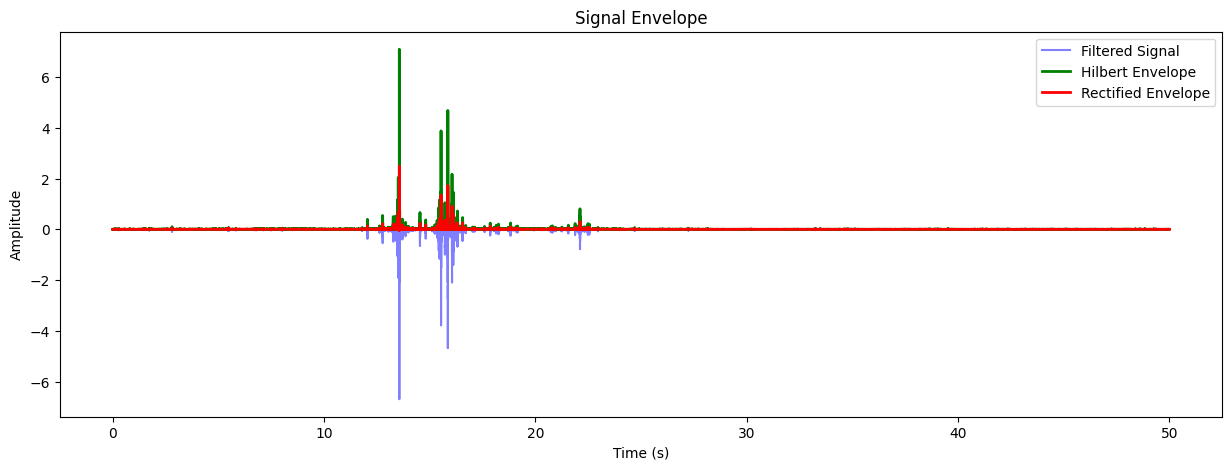

In [51]:
# using the hilbert transform 
nyquist = 0.5 * samplerate
analytic_signal = hilbert(filtered_data)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 100 # # low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(filtered_data))

# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, filtered_data, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(time, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope")
plt.legend(loc='upper right')
#plt.xlim(42.4, 42.7)
#plt.ylim(-5, 5)
plt.savefig("calibration_plots/floods/f2/f2_signal_envelopes_full.png", dpi=300)
plt.show()

Pulse counting and Rectangular waveform

In [52]:
# channel gains (relative multipliers) from 
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

# voltage thresholds for impulse detection
lower_thresh = 2  # volts

# first column of results is the time index of detected impulses
rect_hilbert = pd.DataFrame({'time': time})
rect_rectified = pd.DataFrame({'time': time})

# loop over channels, apply gain, and detect impulses
# for hilbert envelope
for ch, gain in gains.items():
    amplified = envelope_hilbert * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_hilbert[f'ch{ch}'] = rectangular

# for rectified envelope
for ch, gain in gains.items():
    amplified = envelope_rectified * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_rectified[f'ch{ch}'] = rectangular

del amplified, binary, rectangular, ch, gain

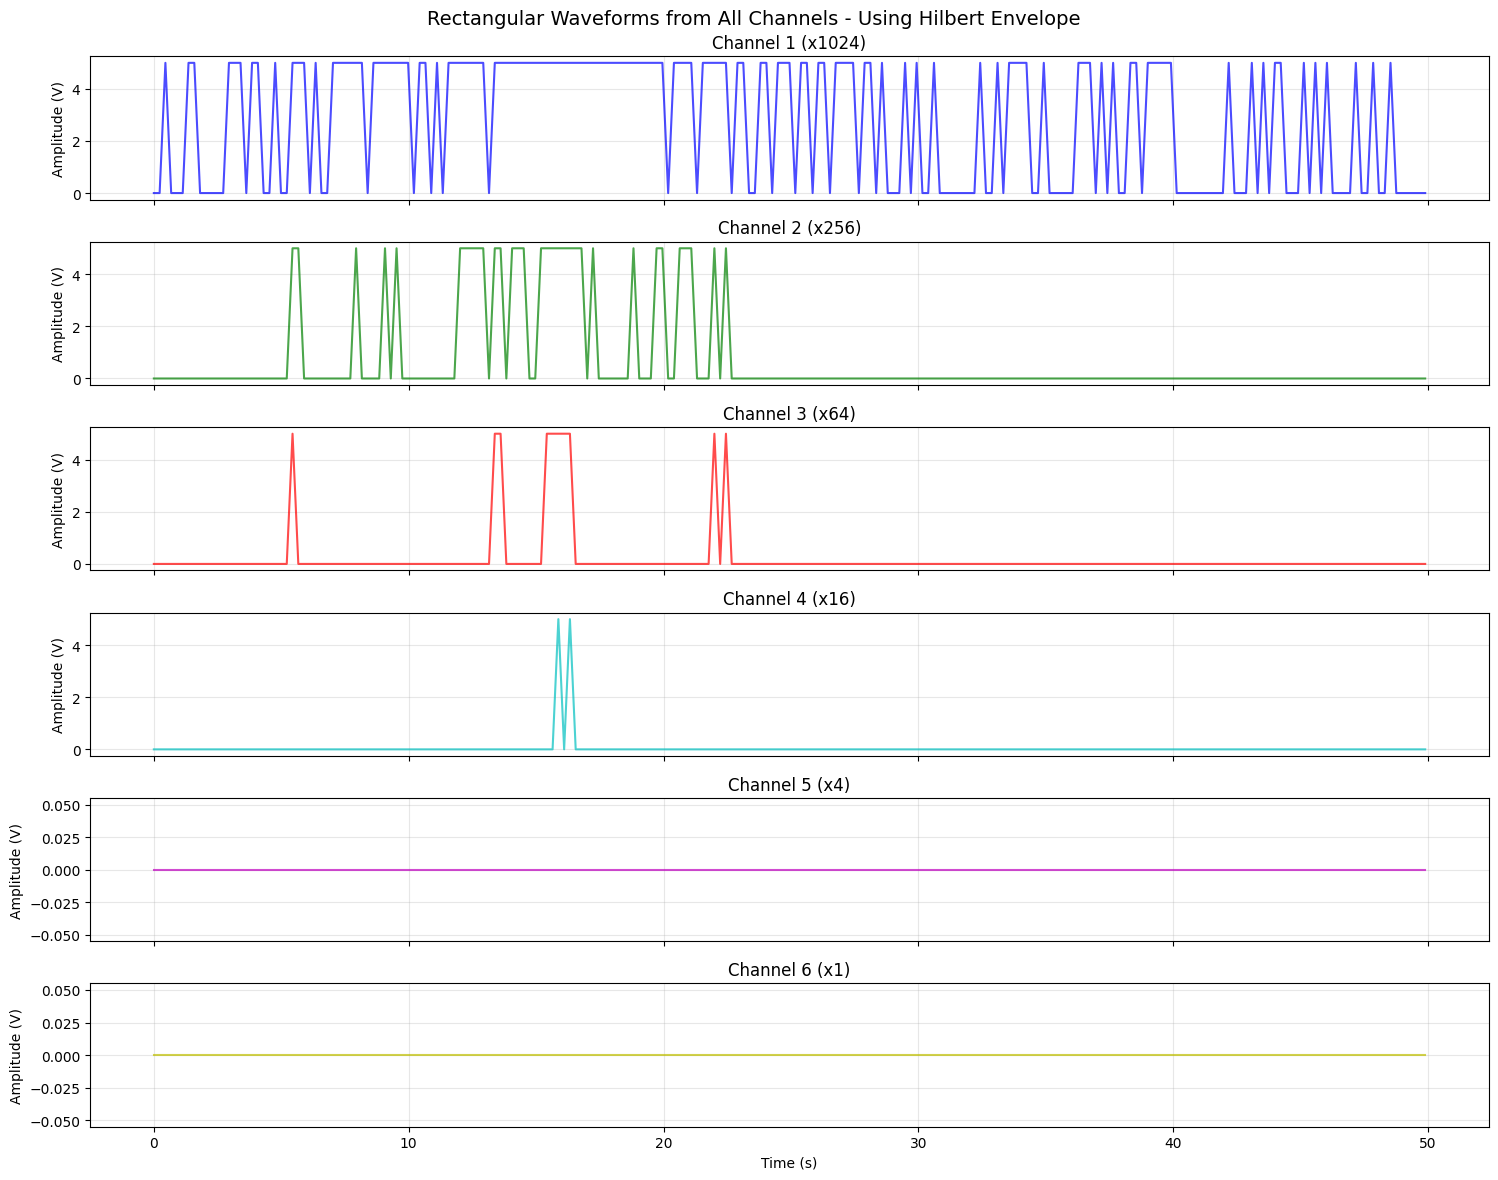

In [53]:
# visualize rect waveforms from hilbert envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000  

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_hilbert['time'][::downsample_factor]
    downsampled_signal = rect_hilbert[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Hilbert Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/floods/f2/f2_rect_from_hilbert.png", dpi=300, bbox_inches='tight')
plt.show()

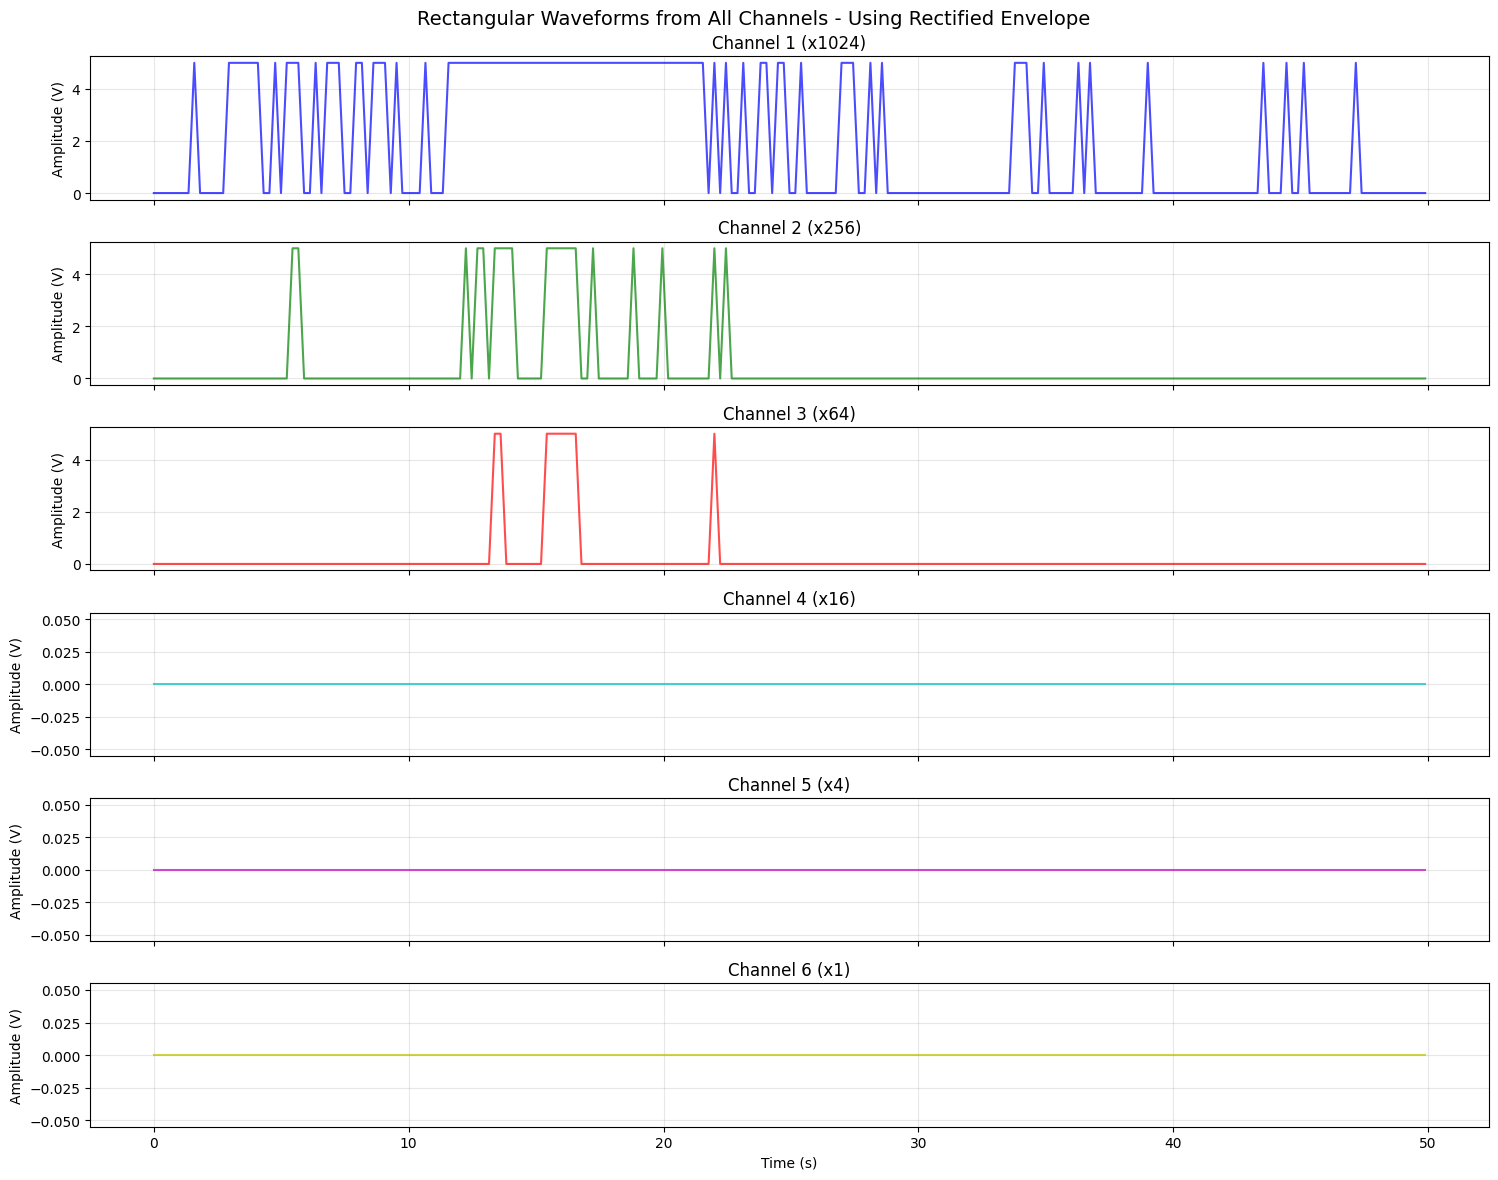

In [54]:
# visualize rect waveforms from rectified envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000 

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_rectified['time'][::downsample_factor]
    downsampled_signal = rect_rectified[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Rectified Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/floods/f2/f2_rect_from_rectified.png", dpi=300, bbox_inches='tight')
plt.show()

Counting pulses by particle impact

In [55]:
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

fs = samplerate  # sampling frequency (Hz)
dt = 1.0         # target bin size in seconds

# build bins
time_bins = np.arange(time[0], time[-1] + dt, dt)
time_index = pd.to_timedelta(time_bins[:-1], unit="s")

# function to count impulses (rising edges) per second
def count_impulses(rect_signal, fs):
    # detect rising edges: 0→5 transitions
    rising_edges = np.diff((rect_signal > 0).astype(int)) == 1
    edge_times = time[1:][rising_edges]
    # bin counts into 1s intervals
    counts, _ = np.histogram(edge_times, bins=time_bins)
    return counts

# prepare output containers
results_hilbert = pd.DataFrame(index=time_index)
results_rectified = pd.DataFrame(index=time_index)
df_env = pd.DataFrame(index=pd.to_timedelta(time, unit="s"))

# 1) count impulses
for ch, gain in gains.items():
    impulses = count_impulses(rect_hilbert[f"ch{ch}"].values, fs)
    results_hilbert[f"impulses_ch{ch}"] = impulses

    impulses = count_impulses(rect_rectified[f"ch{ch}"].values, fs)
    results_rectified[f"impulses_ch{ch}"] = impulses
    # per-channel rect (0–5 V pulse train)
    df_env[f"hil_rect_ch{ch}"] = rect_hilbert[f"ch{ch}"]
    df_env[f"rect_rect_ch{ch}"] = rect_rectified[f"ch{ch}"]
    # per-channel envelope (apply gain to original envelopes)
    df_env[f"hil_env_ch{ch}"] = envelope_hilbert * gain
    df_env[f"rect_env_ch{ch}"] = envelope_rectified * gain

# 2) average envelope amplitude at 1 Hz
# put both hilbert + rectified envelopes into one structure
df_env_combined = pd.DataFrame({
    "time": time,
    "hilbert": envelope_hilbert,
    "rectified": envelope_rectified
})

# resample to 1 Hz (average every second)
df_env_combined.index = pd.to_timedelta(df_env_combined["time"], unit="s")
df_env_1hz = df_env_combined.resample("1s").mean()

# final result: combine counts + averages
final_hilbert = results_hilbert.join(df_env_1hz["hilbert"])
final_rectified = results_rectified.join(df_env_1hz["rectified"])

For Hilber Envelope by Channel 

In [56]:
# add rectangular waveforms to final_hilbert
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_hilbert index
    rect_series = pd.Series(rect_hilbert[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_hilbert * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"env_ch{ch}"] = env_series.resample("1s").mean()

# analyze the entire sampling period as one window
t0 = time.min()  # start of entire period
t1 = time.max()  # end of entire period (should be ~480s)

# use the entire final_hilbert dataframe as the window
window = final_hilbert

# sum impulses per channel over entire period
impulse_sums = window.filter(like="impulses_ch").sum()

# amplitude stats (full envelope during entire period)
max_amp = window["hilbert"].max()
mean_amp = window["hilbert"].mean()
median_amp = window["hilbert"].median()

# collect everything
result = {
    "SampleID": "flood2",  # or whatever identifier you want
    "t0": t0,
    "t1": t1,
    "max_amp": max_amp,
    "mean_amp": mean_amp,
    "median_amp": median_amp,
}
result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses for entire period
for ch in gains.keys():
    rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
    env_col  = f"env_ch{ch}"       # envelope for this channel

    # get rect + envelope for entire period
    rect_sig = final_hilbert[f"rect_ch{ch}"]
    env_sig  = final_hilbert[f"env_ch{ch}"]

    # take only times when impulse (rect = 5V)
    mask = rect_sig > 0 # impulses
    if mask.any():
        result[f"ch{ch}_max"]   = env_sig[mask].max()
        result[f"ch{ch}_mean"]   = env_sig[mask].mean()
        result[f"ch{ch}_median"] = env_sig[mask].median()
    else:
        result[f"ch{ch}_max"]   = np.nan
        result[f"ch{ch}_mean"]   = np.nan
        result[f"ch{ch}_median"] = np.nan

# create single-row dataframe
df_results = pd.DataFrame([result])
df_results.to_csv("EXP-09-20-23-FLOW2/f2_results_hilbert.csv", index=False)

For Rectified Envelope by Channel 

In [57]:
# add rectangular waveforms to final_rectified
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_rectified index
    rect_series = pd.Series(rect_rectified[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_rectified * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"env_ch{ch}"] = env_series.resample("1s").mean()

# analyze the entire sampling period as one window
t0 = time.min()  # start of entire period
t1 = time.max()  # end of entire period (should be ~480s)

# use the entire final_rectified dataframe as the window
window = final_rectified

# sum impulses per channel over entire period
impulse_sums = window.filter(like="impulses_ch").sum()

# amplitude stats (full envelope during entire period)
max_amp = window["rectified"].max()
mean_amp = window["rectified"].mean()
median_amp = window["rectified"].median()

# collect everything
result = {
    "SampleID": "flood2",  # or whatever identifier you want
    "t0": t0,
    "t1": t1,
    "max_amp": max_amp,
    "mean_amp": mean_amp,
    "median_amp": median_amp,
}
result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses for entire period
for ch in gains.keys():
    rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
    env_col  = f"env_ch{ch}"       # envelope for this channel

    # get rect + envelope for entire period
    rect_sig = final_rectified[f"rect_ch{ch}"]
    env_sig  = final_rectified[f"env_ch{ch}"]

    # take only times when impulse (rect = 5V)
    mask = rect_sig > 0 # impulses
    if mask.any():
        result[f"ch{ch}_max"]   = env_sig[mask].max()
        result[f"ch{ch}_mean"]   = env_sig[mask].mean()
        result[f"ch{ch}_median"] = env_sig[mask].median()
    else:
        result[f"ch{ch}_max"]   = np.nan
        result[f"ch{ch}_mean"]   = np.nan
        result[f"ch{ch}_median"] = np.nan

# create single-row dataframe
df_results = pd.DataFrame([result])
df_results.to_csv("EXP-09-20-23-FLOW2/f2_results_rectified.csv", index=False)

## Flood 3

In [58]:
input_flac_file = 'EXP-09-20-23-FLOW3/audio/Nicole_091823-000100.flac'
data, samplerate = sf.read(input_flac_file)

# pipe is left channel 
if data.ndim > 1:
    data = data[:,0] # keep the left channel, which in this case is the impact pipe

Gain Compensation

In [59]:
# for some reason there was a lot of static in the recordings, don't know if it was like a hardware thing? 
preamp_gain_db = 23  # preamp gain in dB for this recording
linear_gain = 10**(preamp_gain_db / 20)
calibrated_data = data / linear_gain

print(f"Sampling Rate: {samplerate} Hz")
print(f"Original data shape: {data.shape}")
print(f"Linear gain factor: {linear_gain:.2f}")

# plot the raw and calibrated waveforms for verification
time = np.arange(len(data)) / samplerate
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))
plt.plot(time, data, label="Raw Digital Data")
plt.plot(time, calibrated_data, label="Gain-Compensated Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs. Gain-Compensated Waveform")
plt.legend(loc='upper right')
# saving instead of showing to avoid space usage issues
plt.savefig("calibration_plots/floods/f3/f3_waveform_comparison.png", dpi=300)
plt.close()

Sampling Rate: 44100 Hz
Original data shape: (52920000,)
Linear gain factor: 14.13


In [61]:
# commenting this out because it takes so long to run
#frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)
#plt.figure(figsize=(15, 6))
#plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
#plt.colorbar(label='Intensity [dB]')
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.title('Acoustic Signal Spectrogram')
#plt.ylim([0, samplerate / 2])  # limit y-axis to Nyquist frequency
#plt.savefig("calibration_plots/floods/f3/f3_spectrogram.png", dpi=300)
#plt.close()
# takes like 15 mins on my laptop

In [62]:
frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)

# average spectrum over time
cols = np.arange(len(times))
spec_avg = Sxx[:, cols].mean(axis=1)
spec_sm = gaussian_filter1d(spec_avg, 2) # smooth with gaussian filter; sigma=2

# plot the averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies, spec_sm, label="Smoothed avg spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: Averaged Spectrum")
plt.tight_layout()
plt.savefig("calibration_plots/floods/f3/f3_time_avg_spectrum.png", dpi=300)
plt.close()

### Band-Pass Filtering 

Filter Data and Amplify

In [63]:
lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

# only keep times between 250 to 350 seconds
calibrated_data = calibrated_data[250*samplerate:350*samplerate]
time = np.arange(len(calibrated_data)) / samplerate

# Debug prints
print(f"Sample rate: {samplerate}")
print(f"Data length after slicing: {len(calibrated_data)}")
print(f"Expected duration: {(660-180)} seconds")
print(f"Actual duration: {len(calibrated_data)/samplerate} seconds")
print(f"Time array min: {time.min()}, max: {time.max()}")

# first band-pass filter the entire calibrated data
filtered_data1 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
filtered_data2 = filtered_data1 * 20

# second band-pass filter
filtered_data3 = band_pass_filter(filtered_data2, samplerate, lowcut, highcut, order=4)
filtered_data = filtered_data3 * 10

# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(time, filtered_data2, label="Filtered (1st)", color='red', alpha=0.7)
plt.plot(time, filtered_data3, label="Filtered (2nd)", color='blue', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signals (Without Amplification)")
plt.legend(loc='upper right')
twin = plt.twinx()
twin.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)

#plt.xlim(41.9, 42)  # zoom in to see details
plt.savefig("calibration_plots/floods/f3/f3_bandpass_filtered_signals_full.png", dpi=300)
plt.close()

Sample rate: 44100
Data length after slicing: 4410000
Expected duration: 480 seconds
Actual duration: 100.0 seconds
Time array min: 0.0, max: 99.99997732426304


### Envelope Detection

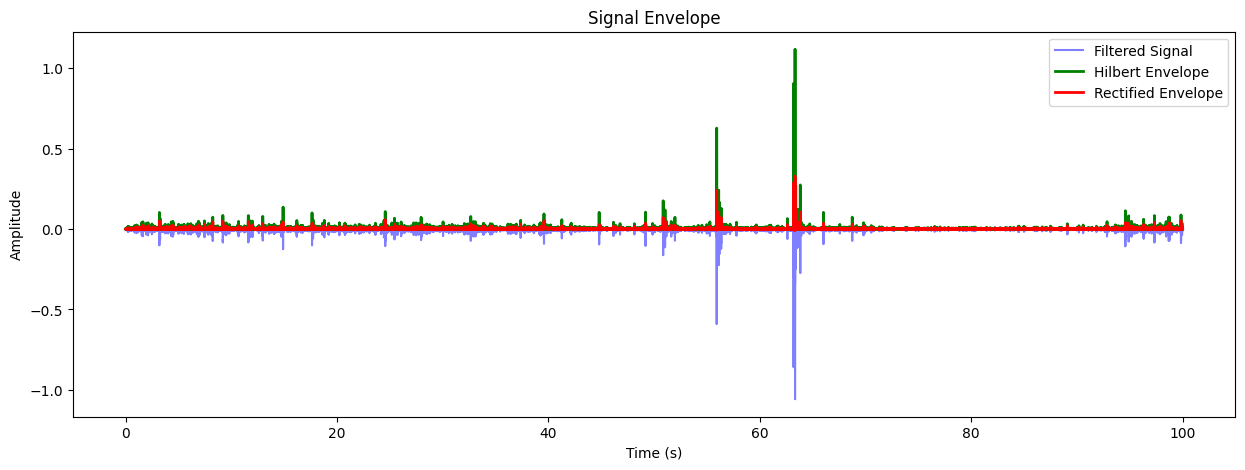

In [64]:
# using the hilbert transform 
nyquist = 0.5 * samplerate
analytic_signal = hilbert(filtered_data)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 100 # # low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(filtered_data))

# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, filtered_data, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(time, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope")
plt.legend(loc='upper right')
#plt.xlim(42.4, 42.7)
#plt.ylim(-5, 5)
plt.savefig("calibration_plots/floods/f3/f3_signal_envelopes_full.png", dpi=300)
plt.show()

Pulse counting and rectangular waveform

In [65]:
# channel gains (relative multipliers) from 
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

# voltage thresholds for impulse detection
lower_thresh = 2  # volts

# first column of results is the time index of detected impulses
rect_hilbert = pd.DataFrame({'time': time})
rect_rectified = pd.DataFrame({'time': time})

# loop over channels, apply gain, and detect impulses
# for hilbert envelope
for ch, gain in gains.items():
    amplified = envelope_hilbert * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_hilbert[f'ch{ch}'] = rectangular

# for rectified envelope
for ch, gain in gains.items():
    amplified = envelope_rectified * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_rectified[f'ch{ch}'] = rectangular

del amplified, binary, rectangular, ch, gain

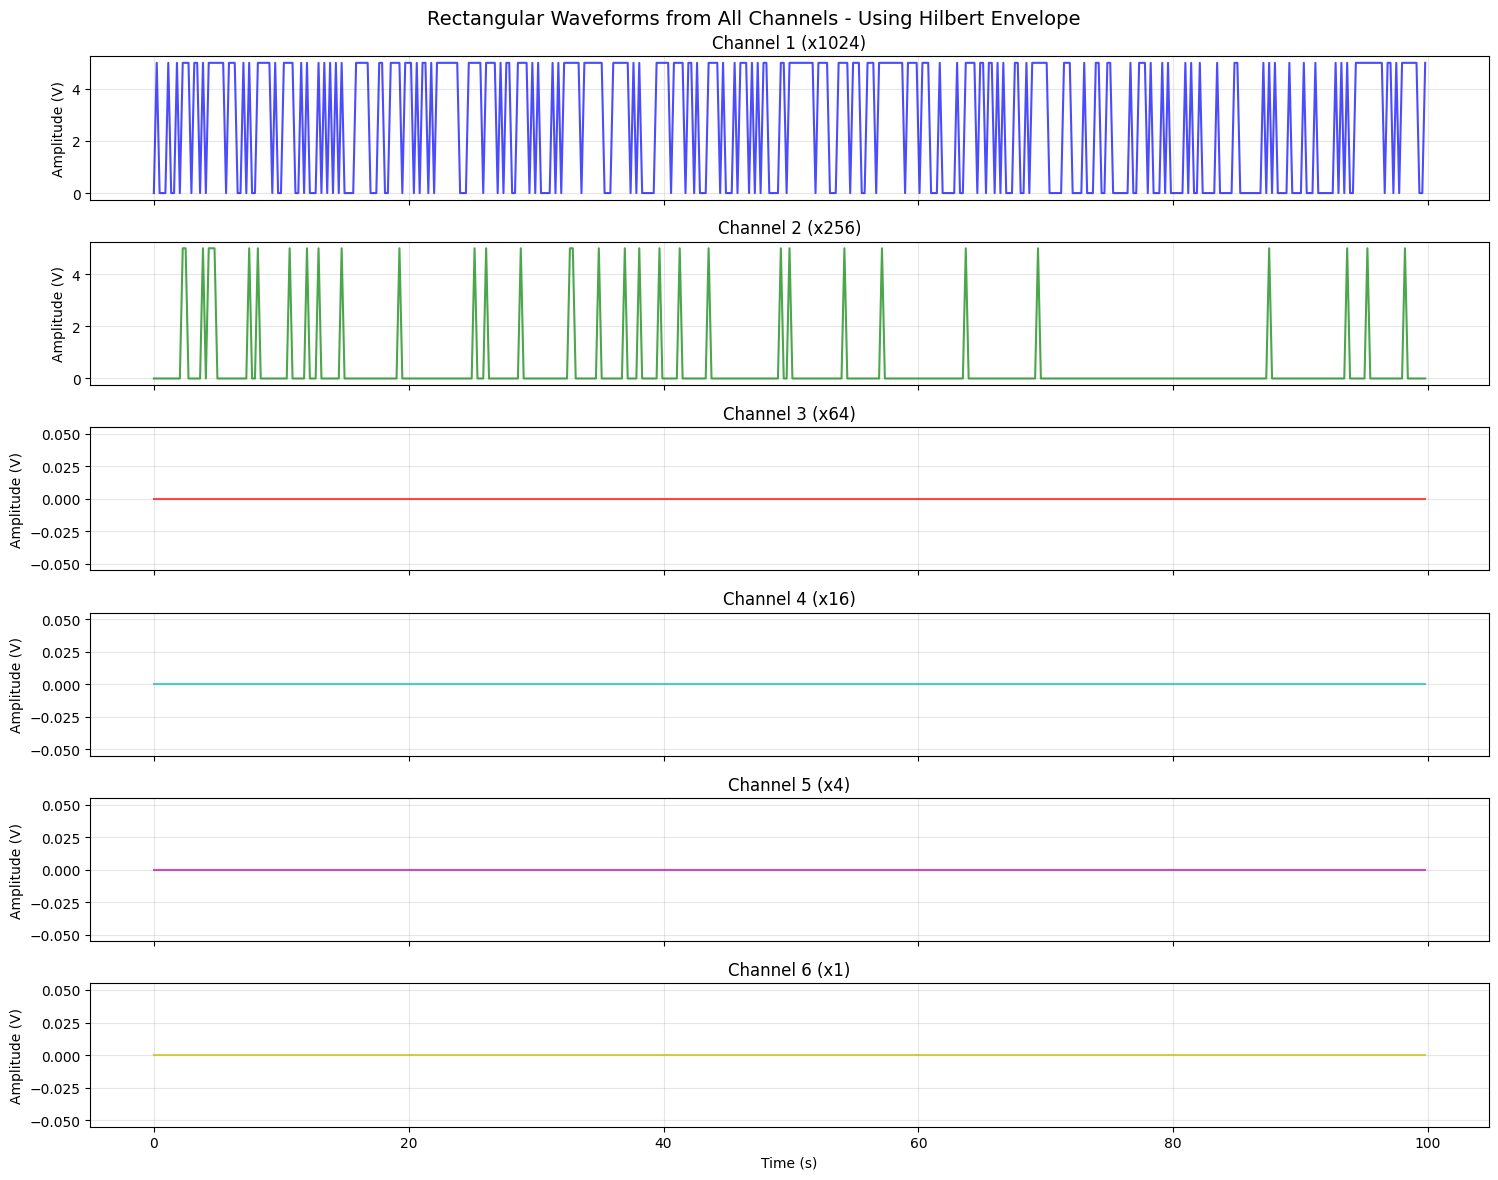

In [66]:
# visualize rect waveforms from hilbert envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000  

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_hilbert['time'][::downsample_factor]
    downsampled_signal = rect_hilbert[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Hilbert Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/floods/f3/f3_rect_from_hilbert.png", dpi=300, bbox_inches='tight')
plt.show()

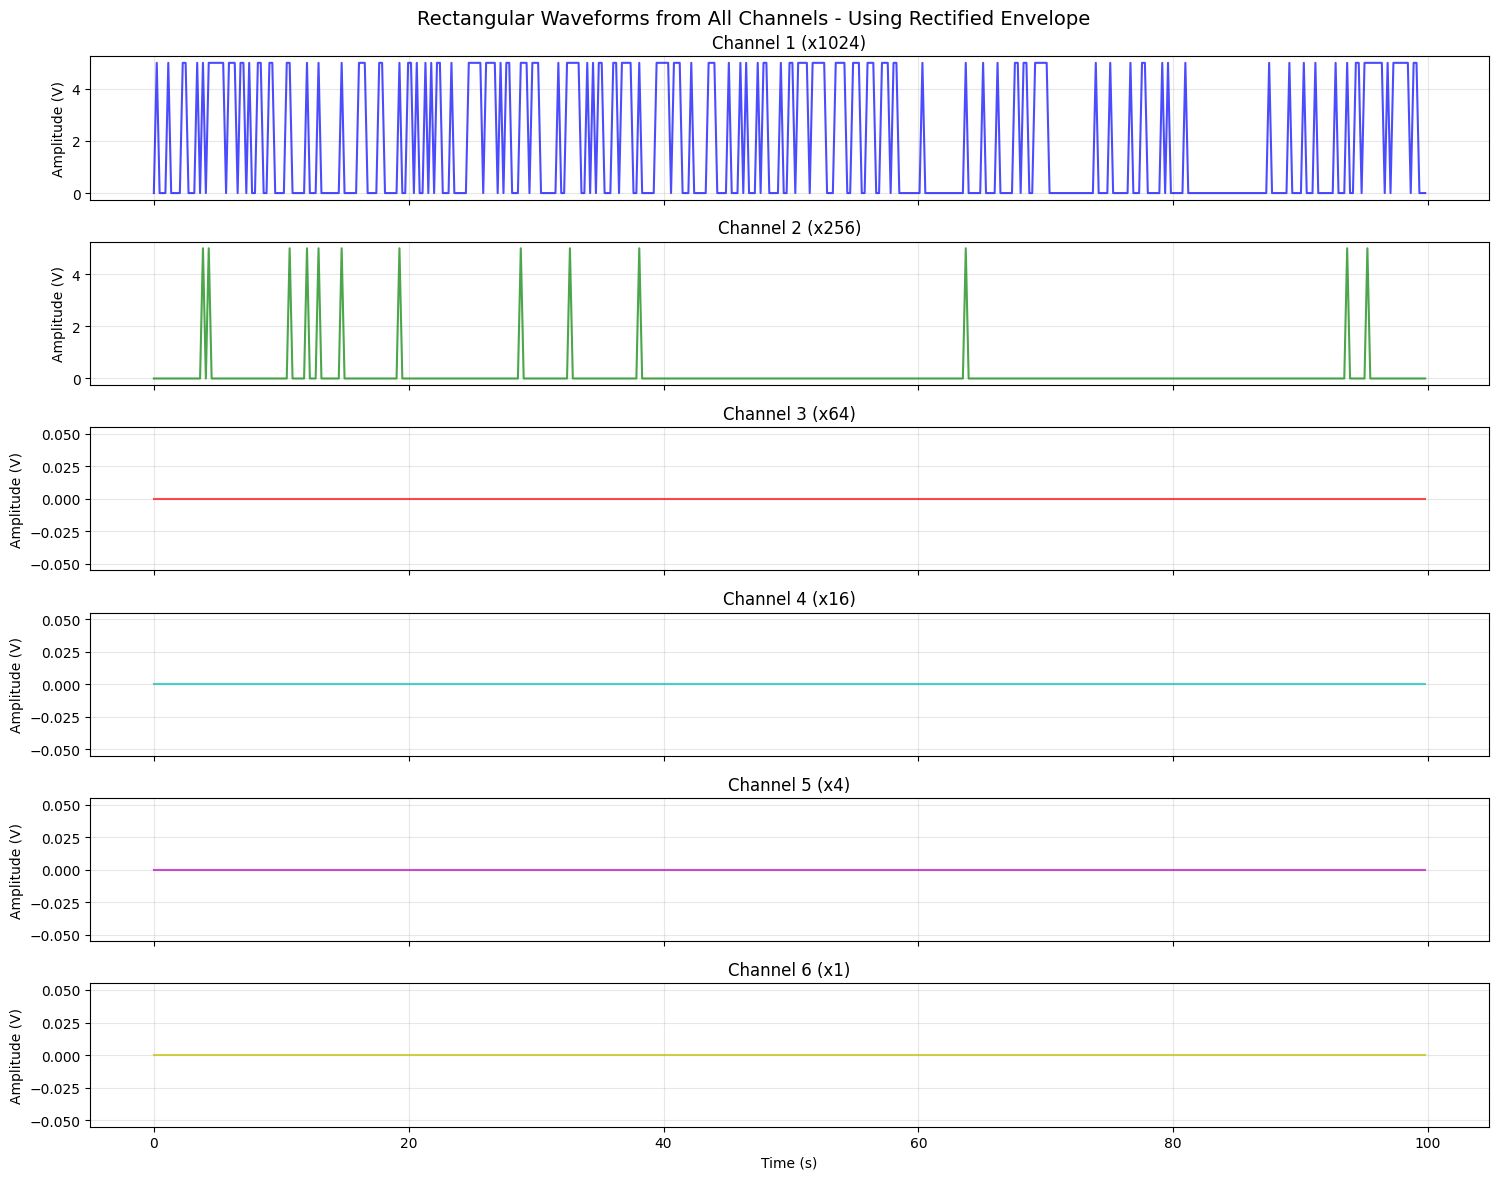

In [67]:
# visualize rect waveforms from rectified envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000 

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_rectified['time'][::downsample_factor]
    downsampled_signal = rect_rectified[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Rectified Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/floods/f3/f3_rect_from_rectified.png", dpi=300, bbox_inches='tight')
plt.show()

Counting pulses by particle impact

In [68]:
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

fs = samplerate  # sampling frequency (Hz)
dt = 1.0         # target bin size in seconds

# build bins
time_bins = np.arange(time[0], time[-1] + dt, dt)
time_index = pd.to_timedelta(time_bins[:-1], unit="s")

# function to count impulses (rising edges) per second
def count_impulses(rect_signal, fs):
    # detect rising edges: 0→5 transitions
    rising_edges = np.diff((rect_signal > 0).astype(int)) == 1
    edge_times = time[1:][rising_edges]
    # bin counts into 1s intervals
    counts, _ = np.histogram(edge_times, bins=time_bins)
    return counts

# prepare output containers
results_hilbert = pd.DataFrame(index=time_index)
results_rectified = pd.DataFrame(index=time_index)
df_env = pd.DataFrame(index=pd.to_timedelta(time, unit="s"))

# 1) count impulses
for ch, gain in gains.items():
    impulses = count_impulses(rect_hilbert[f"ch{ch}"].values, fs)
    results_hilbert[f"impulses_ch{ch}"] = impulses

    impulses = count_impulses(rect_rectified[f"ch{ch}"].values, fs)
    results_rectified[f"impulses_ch{ch}"] = impulses
    # per-channel rect (0–5 V pulse train)
    df_env[f"hil_rect_ch{ch}"] = rect_hilbert[f"ch{ch}"]
    df_env[f"rect_rect_ch{ch}"] = rect_rectified[f"ch{ch}"]
    # per-channel envelope (apply gain to original envelopes)
    df_env[f"hil_env_ch{ch}"] = envelope_hilbert * gain
    df_env[f"rect_env_ch{ch}"] = envelope_rectified * gain

# 2) average envelope amplitude at 1 Hz
# put both hilbert + rectified envelopes into one structure
df_env_combined = pd.DataFrame({
    "time": time,
    "hilbert": envelope_hilbert,
    "rectified": envelope_rectified
})

# resample to 1 Hz (average every second)
df_env_combined.index = pd.to_timedelta(df_env_combined["time"], unit="s")
df_env_1hz = df_env_combined.resample("1s").mean()

# final result: combine counts + averages
final_hilbert = results_hilbert.join(df_env_1hz["hilbert"])
final_rectified = results_rectified.join(df_env_1hz["rectified"])

For Hilbert Envelope by Channel 

In [69]:
# add rectangular waveforms to final_hilbert
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_hilbert index
    rect_series = pd.Series(rect_hilbert[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_hilbert * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"env_ch{ch}"] = env_series.resample("1s").mean()

# analyze the entire sampling period as one window
t0 = time.min()  # start of entire period
t1 = time.max()  # end of entire period (should be ~480s)

# use the entire final_hilbert dataframe as the window
window = final_hilbert

# sum impulses per channel over entire period
impulse_sums = window.filter(like="impulses_ch").sum()

# amplitude stats (full envelope during entire period)
max_amp = window["hilbert"].max()
mean_amp = window["hilbert"].mean()
median_amp = window["hilbert"].median()

# collect everything
result = {
    "SampleID": "flood3",  # or whatever identifier you want
    "t0": t0,
    "t1": t1,
    "max_amp": max_amp,
    "mean_amp": mean_amp,
    "median_amp": median_amp,
}
result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses for entire period
for ch in gains.keys():
    rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
    env_col  = f"env_ch{ch}"       # envelope for this channel

    # get rect + envelope for entire period
    rect_sig = final_hilbert[f"rect_ch{ch}"]
    env_sig  = final_hilbert[f"env_ch{ch}"]

    # take only times when impulse (rect = 5V)
    mask = rect_sig > 0 # impulses
    if mask.any():
        result[f"ch{ch}_max"]   = env_sig[mask].max()
        result[f"ch{ch}_mean"]   = env_sig[mask].mean()
        result[f"ch{ch}_median"] = env_sig[mask].median()
    else:
        result[f"ch{ch}_max"]   = np.nan
        result[f"ch{ch}_mean"]   = np.nan
        result[f"ch{ch}_median"] = np.nan

# create single-row dataframe
df_results = pd.DataFrame([result])
df_results.to_csv("EXP-09-20-23-FLOW3/f3_results_hilbert.csv", index=False)

For Rectified Envelope by Channel 

In [70]:
# add rectangular waveforms to final_rectified
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_rectified index
    rect_series = pd.Series(rect_rectified[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_rectified * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"env_ch{ch}"] = env_series.resample("1s").mean()

# analyze the entire sampling period as one window
t0 = time.min()  # start of entire period
t1 = time.max()  # end of entire period (should be ~480s)

# use the entire final_rectified dataframe as the window
window = final_rectified

# sum impulses per channel over entire period
impulse_sums = window.filter(like="impulses_ch").sum()

# amplitude stats (full envelope during entire period)
max_amp = window["rectified"].max()
mean_amp = window["rectified"].mean()
median_amp = window["rectified"].median()

# collect everything
result = {
    "SampleID": "flood3",  # or whatever identifier you want
    "t0": t0,
    "t1": t1,
    "max_amp": max_amp,
    "mean_amp": mean_amp,
    "median_amp": median_amp,
}
result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses for entire period
for ch in gains.keys():
    rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
    env_col  = f"env_ch{ch}"       # envelope for this channel

    # get rect + envelope for entire period
    rect_sig = final_rectified[f"rect_ch{ch}"]
    env_sig  = final_rectified[f"env_ch{ch}"]

    # take only times when impulse (rect = 5V)
    mask = rect_sig > 0 # impulses
    if mask.any():
        result[f"ch{ch}_max"]   = env_sig[mask].max()
        result[f"ch{ch}_mean"]   = env_sig[mask].mean()
        result[f"ch{ch}_median"] = env_sig[mask].median()
    else:
        result[f"ch{ch}_max"]   = np.nan
        result[f"ch{ch}_mean"]   = np.nan
        result[f"ch{ch}_median"] = np.nan

# create single-row dataframe
df_results = pd.DataFrame([result])
df_results.to_csv("EXP-09-20-23-FLOW3/f3_results_rectified.csv", index=False)

## Flood 4

In [71]:
input_flac_file = 'EXP-09-21-23-FLOW4/audio/Nicole_091823-000100.flac'
data, samplerate = sf.read(input_flac_file)

# pipe is left channel 
if data.ndim > 1:
    data = data[:,0] # keep the left channel, which in this case is the impact pipe

Gain Compensation

In [72]:
# for some reason there was a lot of static in the recordings, don't know if it was like a hardware thing? 
preamp_gain_db = 23  # preamp gain in dB for this recording
linear_gain = 10**(preamp_gain_db / 20)
calibrated_data = data / linear_gain

print(f"Sampling Rate: {samplerate} Hz")
print(f"Original data shape: {data.shape}")
print(f"Linear gain factor: {linear_gain:.2f}")

# plot the raw and calibrated waveforms for verification
time = np.arange(len(data)) / samplerate
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))
plt.plot(time, data, label="Raw Digital Data")
plt.plot(time, calibrated_data, label="Gain-Compensated Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs. Gain-Compensated Waveform")
plt.legend(loc='upper right')
# saving instead of showing to avoid space usage issues
plt.savefig("calibration_plots/floods/f4/f4_waveform_comparison.png", dpi=300)
plt.close()

Sampling Rate: 44100 Hz
Original data shape: (52920000,)
Linear gain factor: 14.13


In [73]:
# commenting this out because it takes so long to run
#frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)
#plt.figure(figsize=(15, 6))
#plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
#plt.colorbar(label='Intensity [dB]') 
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.title('Acoustic Signal Spectrogram')
#plt.ylim([0, samplerate / 2])  # limit y-axis to Nyquist frequency
#plt.savefig("calibration_plots/floods/f4/f4_spectrogram.png", dpi=300)
#plt.close()
# takes like 15 mins on my laptop

In [74]:
frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)

# average spectrum over time
cols = np.arange(len(times))
spec_avg = Sxx[:, cols].mean(axis=1)
spec_sm = gaussian_filter1d(spec_avg, 2) # smooth with gaussian filter; sigma=2

# plot the averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies, spec_sm, label="Smoothed avg spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: Averaged Spectrum")
plt.tight_layout()
plt.savefig("calibration_plots/floods/f4/f4_time_avg_spectrum.png", dpi=300)
plt.close()

### Band-Pass Filtering

Filter data and amplify

In [75]:
lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

# only keep times between 600 to 800 seconds
calibrated_data = calibrated_data[600*samplerate:800*samplerate]
time = np.arange(len(calibrated_data)) / samplerate

# Debug prints
print(f"Sample rate: {samplerate}")
print(f"Data length after slicing: {len(calibrated_data)}")
print(f"Expected duration: {(660-180)} seconds")
print(f"Actual duration: {len(calibrated_data)/samplerate} seconds")
print(f"Time array min: {time.min()}, max: {time.max()}")

# first band-pass filter the entire calibrated data
filtered_data1 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
filtered_data2 = filtered_data1 * 20

# second band-pass filter
filtered_data3 = band_pass_filter(filtered_data2, samplerate, lowcut, highcut, order=4)
filtered_data = filtered_data3 * 10

# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(time, filtered_data2, label="Filtered (1st)", color='red', alpha=0.7)
plt.plot(time, filtered_data3, label="Filtered (2nd)", color='blue', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signals (Without Amplification)")
plt.legend(loc='upper right')
twin = plt.twinx()
twin.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)

#plt.xlim(41.9, 42)  # zoom in to see details
plt.savefig("calibration_plots/floods/f4/f4_bandpass_filtered_signals_full.png", dpi=300)
plt.close()

Sample rate: 44100
Data length after slicing: 8820000
Expected duration: 480 seconds
Actual duration: 200.0 seconds
Time array min: 0.0, max: 199.99997732426303


### Envelope Detection

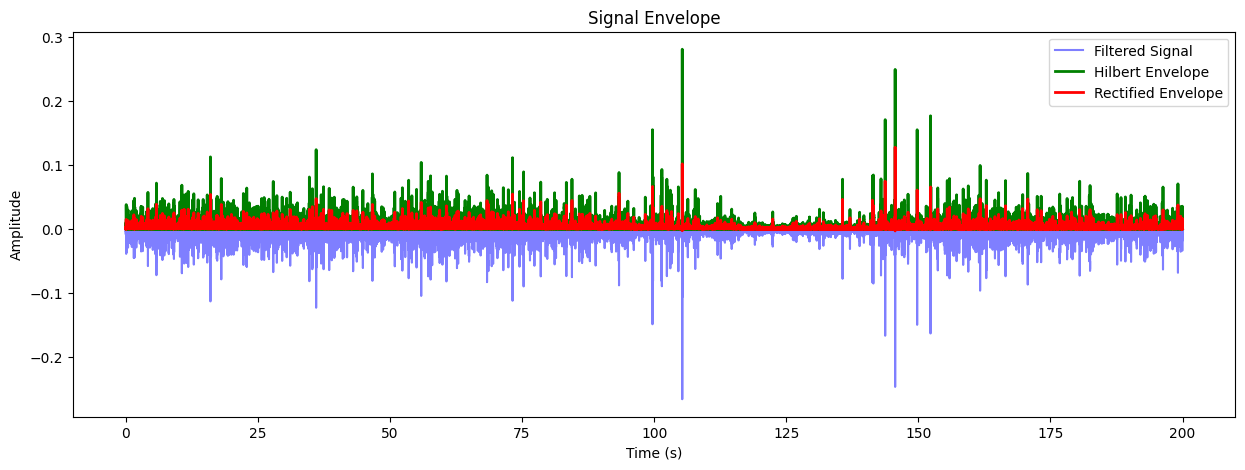

In [76]:
# using the hilbert transform 
nyquist = 0.5 * samplerate
analytic_signal = hilbert(filtered_data)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 100 # # low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(filtered_data))

# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, filtered_data, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(time, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope")
plt.legend(loc='upper right')
#plt.xlim(42.4, 42.7)
#plt.ylim(-5, 5)
plt.savefig("calibration_plots/floods/f4/f4_signal_envelopes_full.png", dpi=300)
plt.show()

Pulse counting and rectangular waveform

In [77]:
# channel gains (relative multipliers) from 
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

# voltage thresholds for impulse detection
lower_thresh = 2  # volts

# first column of results is the time index of detected impulses
rect_hilbert = pd.DataFrame({'time': time})
rect_rectified = pd.DataFrame({'time': time})

# loop over channels, apply gain, and detect impulses
# for hilbert envelope
for ch, gain in gains.items():
    amplified = envelope_hilbert * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_hilbert[f'ch{ch}'] = rectangular

# for rectified envelope
for ch, gain in gains.items():
    amplified = envelope_rectified * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_rectified[f'ch{ch}'] = rectangular

del amplified, binary, rectangular, ch, gain

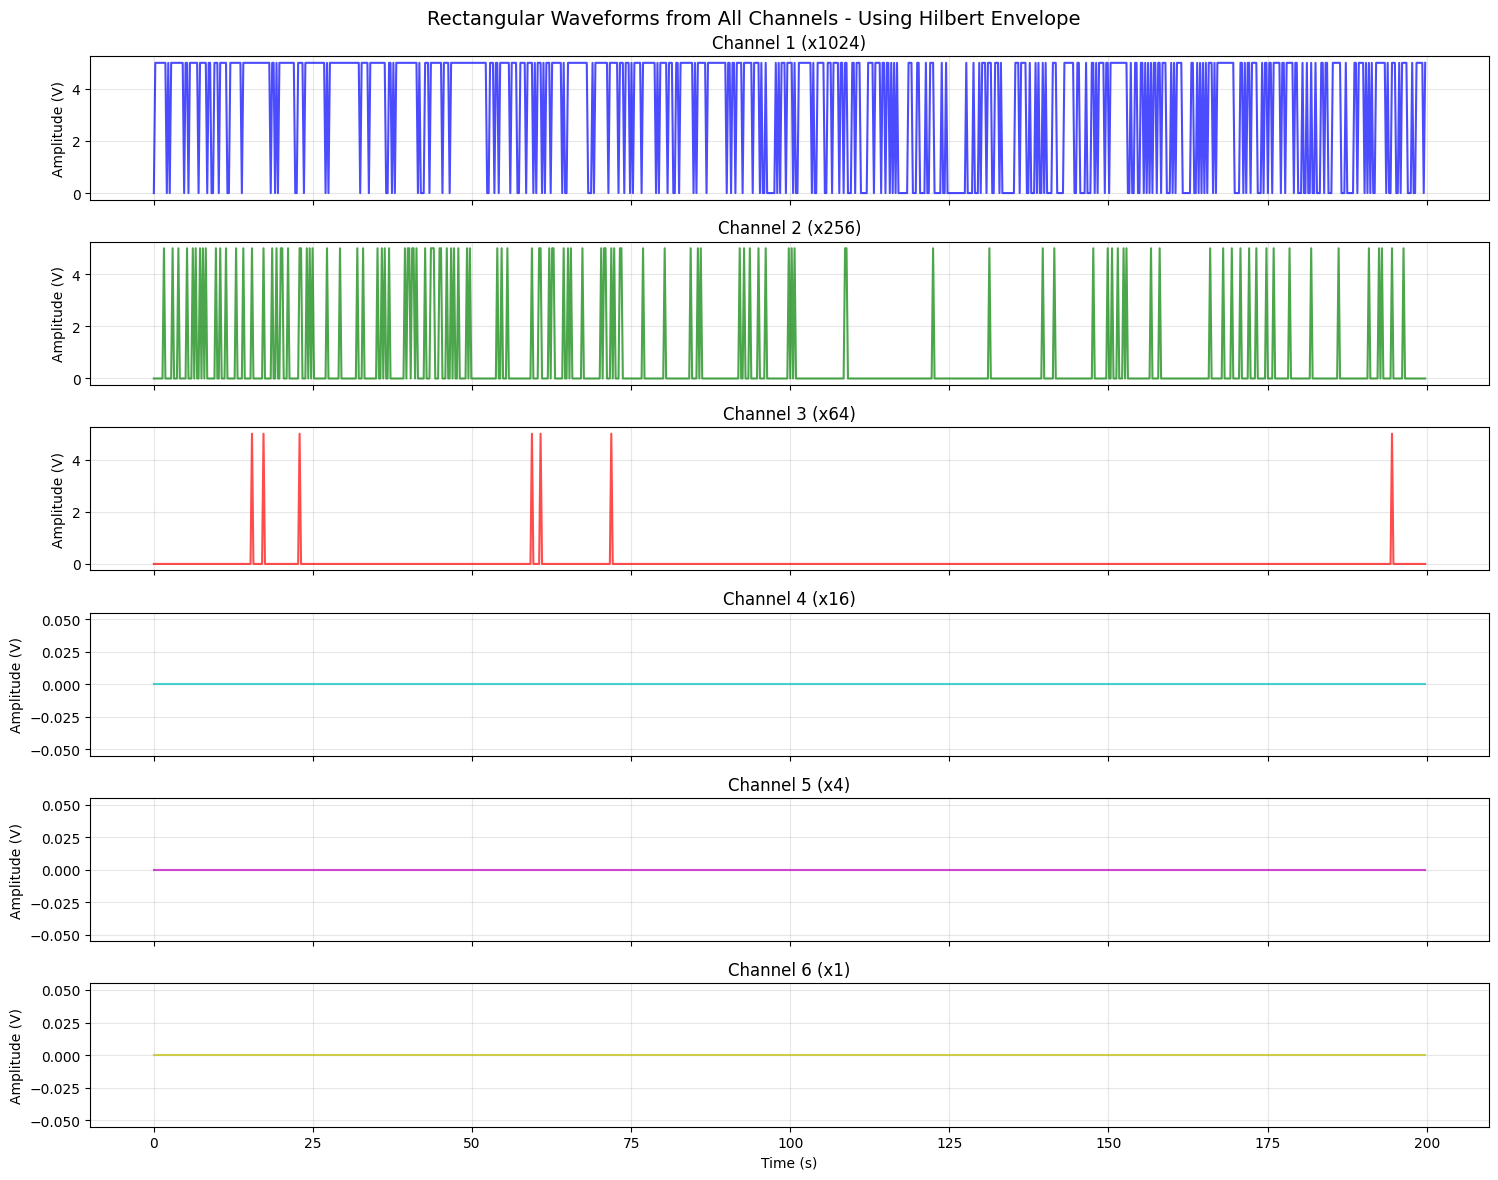

In [78]:
# visualize rect waveforms from hilbert envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000  

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_hilbert['time'][::downsample_factor]
    downsampled_signal = rect_hilbert[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Hilbert Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/floods/f4/f4_rect_from_hilbert.png", dpi=300, bbox_inches='tight')
plt.show()

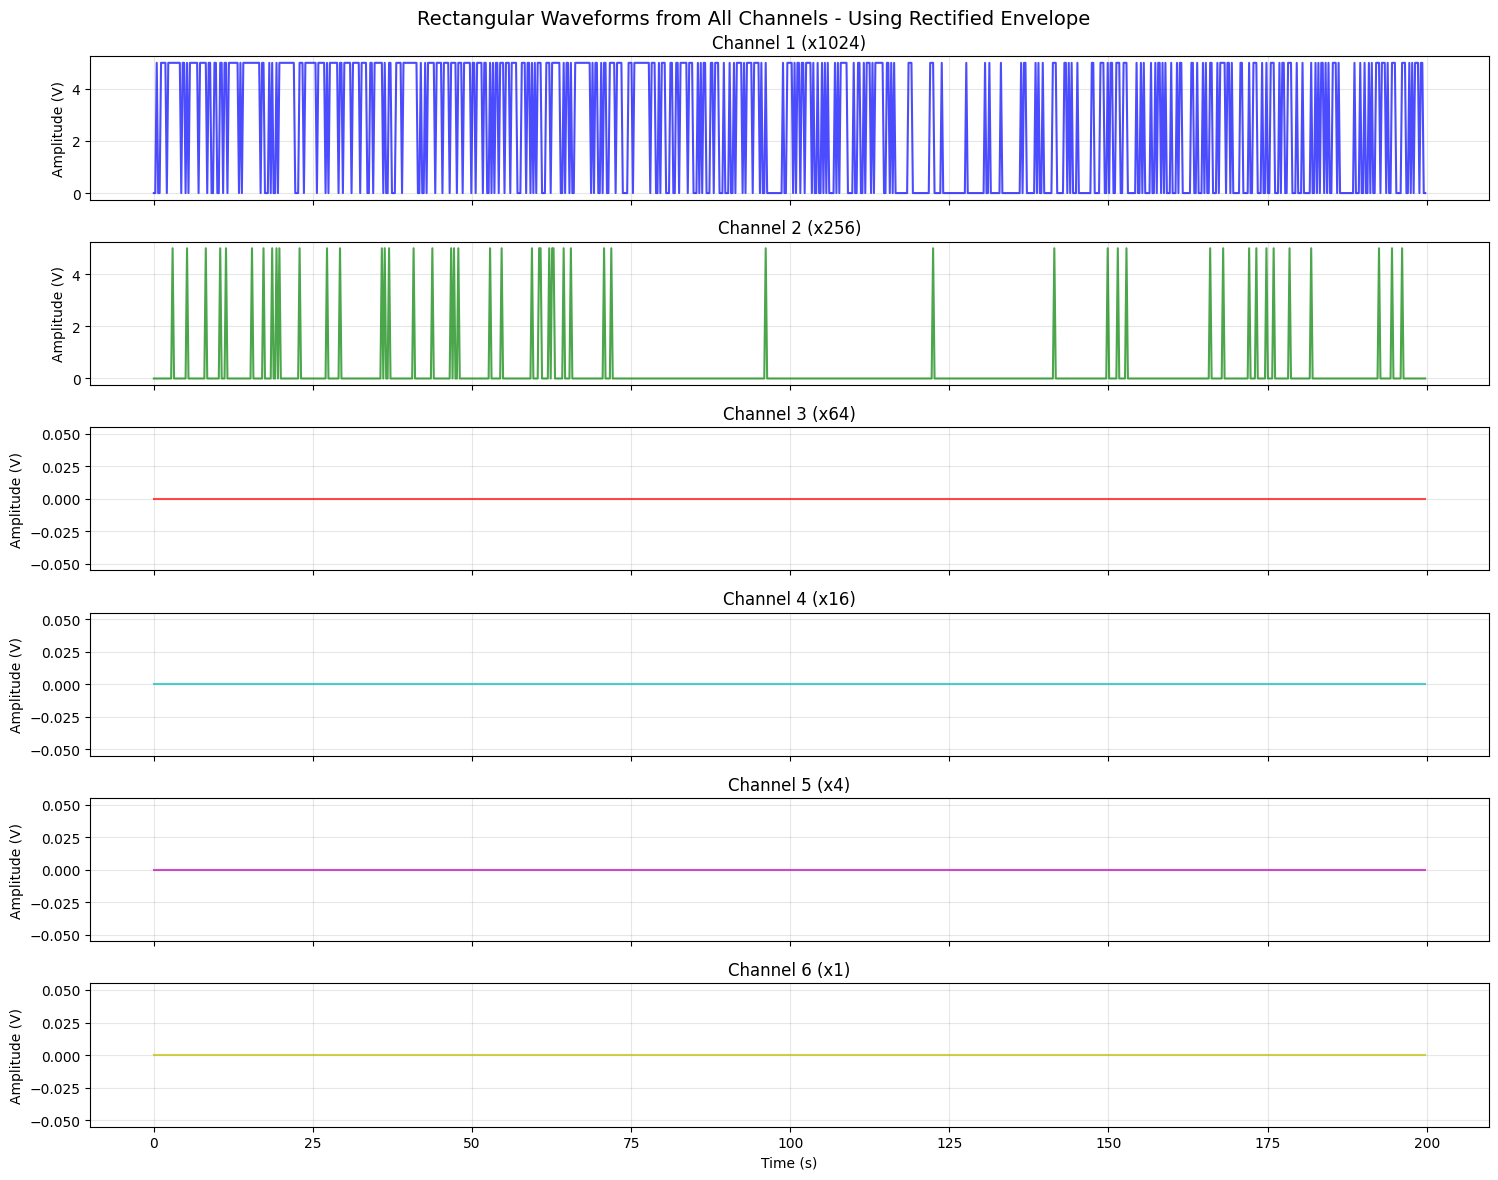

In [79]:
# visualize rect waveforms from rectified envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000 

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_rectified['time'][::downsample_factor]
    downsampled_signal = rect_rectified[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Rectified Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/floods/f4/f4_rect_from_rectified.png", dpi=300, bbox_inches='tight')
plt.show()

Counting pulses by particle impact

In [80]:
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

fs = samplerate  # sampling frequency (Hz)
dt = 1.0         # target bin size in seconds

# build bins
time_bins = np.arange(time[0], time[-1] + dt, dt)
time_index = pd.to_timedelta(time_bins[:-1], unit="s")

# function to count impulses (rising edges) per second
def count_impulses(rect_signal, fs):
    # detect rising edges: 0→5 transitions
    rising_edges = np.diff((rect_signal > 0).astype(int)) == 1
    edge_times = time[1:][rising_edges]
    # bin counts into 1s intervals
    counts, _ = np.histogram(edge_times, bins=time_bins)
    return counts

# prepare output containers
results_hilbert = pd.DataFrame(index=time_index)
results_rectified = pd.DataFrame(index=time_index)
df_env = pd.DataFrame(index=pd.to_timedelta(time, unit="s"))

# 1) count impulses
for ch, gain in gains.items():
    impulses = count_impulses(rect_hilbert[f"ch{ch}"].values, fs)
    results_hilbert[f"impulses_ch{ch}"] = impulses

    impulses = count_impulses(rect_rectified[f"ch{ch}"].values, fs)
    results_rectified[f"impulses_ch{ch}"] = impulses
    # per-channel rect (0–5 V pulse train)
    df_env[f"hil_rect_ch{ch}"] = rect_hilbert[f"ch{ch}"]
    df_env[f"rect_rect_ch{ch}"] = rect_rectified[f"ch{ch}"]
    # per-channel envelope (apply gain to original envelopes)
    df_env[f"hil_env_ch{ch}"] = envelope_hilbert * gain
    df_env[f"rect_env_ch{ch}"] = envelope_rectified * gain

# 2) average envelope amplitude at 1 Hz
# put both hilbert + rectified envelopes into one structure
df_env_combined = pd.DataFrame({
    "time": time,
    "hilbert": envelope_hilbert,
    "rectified": envelope_rectified
})

# resample to 1 Hz (average every second)
df_env_combined.index = pd.to_timedelta(df_env_combined["time"], unit="s")
df_env_1hz = df_env_combined.resample("1s").mean()

# final result: combine counts + averages
final_hilbert = results_hilbert.join(df_env_1hz["hilbert"])
final_rectified = results_rectified.join(df_env_1hz["rectified"])

For Hilbert Envelope by Channel

In [81]:
# add rectangular waveforms to final_hilbert
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_hilbert index
    rect_series = pd.Series(rect_hilbert[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_hilbert * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"env_ch{ch}"] = env_series.resample("1s").mean()

# analyze the entire sampling period as one window
t0 = time.min()  # start of entire period
t1 = time.max()  # end of entire period (should be ~480s)

# use the entire final_hilbert dataframe as the window
window = final_hilbert

# sum impulses per channel over entire period
impulse_sums = window.filter(like="impulses_ch").sum()

# amplitude stats (full envelope during entire period)
max_amp = window["hilbert"].max()
mean_amp = window["hilbert"].mean()
median_amp = window["hilbert"].median()

# collect everything
result = {
    "SampleID": "flood4",  # or whatever identifier you want
    "t0": t0,
    "t1": t1,
    "max_amp": max_amp,
    "mean_amp": mean_amp,
    "median_amp": median_amp,
}
result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses for entire period
for ch in gains.keys():
    rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
    env_col  = f"env_ch{ch}"       # envelope for this channel

    # get rect + envelope for entire period
    rect_sig = final_hilbert[f"rect_ch{ch}"]
    env_sig  = final_hilbert[f"env_ch{ch}"]

    # take only times when impulse (rect = 5V)
    mask = rect_sig > 0 # impulses
    if mask.any():
        result[f"ch{ch}_max"]   = env_sig[mask].max()
        result[f"ch{ch}_mean"]   = env_sig[mask].mean()
        result[f"ch{ch}_median"] = env_sig[mask].median()
    else:
        result[f"ch{ch}_max"]   = np.nan
        result[f"ch{ch}_mean"]   = np.nan
        result[f"ch{ch}_median"] = np.nan

# create single-row dataframe
df_results = pd.DataFrame([result])
df_results.to_csv("EXP-09-21-23-FLOW4/f4_results_hilbert.csv", index=False)

For Rectified Envelope by Channel

In [82]:
# add rectangular waveforms to final_rectified
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_rectified index
    rect_series = pd.Series(rect_rectified[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_rectified * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"env_ch{ch}"] = env_series.resample("1s").mean()

# analyze the entire sampling period as one window
t0 = time.min()  # start of entire period
t1 = time.max()  # end of entire period (should be ~480s)

# use the entire final_rectified dataframe as the window
window = final_rectified

# sum impulses per channel over entire period
impulse_sums = window.filter(like="impulses_ch").sum()

# amplitude stats (full envelope during entire period)
max_amp = window["rectified"].max()
mean_amp = window["rectified"].mean()
median_amp = window["rectified"].median()

# collect everything
result = {
    "SampleID": "flood4",  # or whatever identifier you want
    "t0": t0,
    "t1": t1,
    "max_amp": max_amp,
    "mean_amp": mean_amp,
    "median_amp": median_amp,
}
result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses for entire period
for ch in gains.keys():
    rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
    env_col  = f"env_ch{ch}"       # envelope for this channel

    # get rect + envelope for entire period
    rect_sig = final_rectified[f"rect_ch{ch}"]
    env_sig  = final_rectified[f"env_ch{ch}"]

    # take only times when impulse (rect = 5V)
    mask = rect_sig > 0 # impulses
    if mask.any():
        result[f"ch{ch}_max"]   = env_sig[mask].max()
        result[f"ch{ch}_mean"]   = env_sig[mask].mean()
        result[f"ch{ch}_median"] = env_sig[mask].median()
    else:
        result[f"ch{ch}_max"]   = np.nan
        result[f"ch{ch}_mean"]   = np.nan
        result[f"ch{ch}_median"] = np.nan

# create single-row dataframe
df_results = pd.DataFrame([result])
df_results.to_csv("EXP-09-21-23-FLOW4/f4_results_rectified.csv", index=False)

## Flood 5

In [83]:
input_flac_file = 'EXP-09-21-23-FLOW5/audio/Nicole_091823-000100.flac'
data, samplerate = sf.read(input_flac_file)

# pipe is left channel 
if data.ndim > 1:
    data = data[:,0] # keep the left channel, which in this case is the impact pipe

Gain Compensation

In [84]:
# for some reason there was a lot of static in the recordings, don't know if it was like a hardware thing? 
preamp_gain_db = 23  # preamp gain in dB for this recording
linear_gain = 10**(preamp_gain_db / 20)
calibrated_data = data / linear_gain

print(f"Sampling Rate: {samplerate} Hz")
print(f"Original data shape: {data.shape}")
print(f"Linear gain factor: {linear_gain:.2f}")

# plot the raw and calibrated waveforms for verification
time = np.arange(len(data)) / samplerate
# note this took 2-minutes to run
plt.figure(figsize=(12, 6))
plt.plot(time, data, label="Raw Digital Data")
plt.plot(time, calibrated_data, label="Gain-Compensated Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Original vs. Gain-Compensated Waveform")
plt.legend(loc='upper right')
# saving instead of showing to avoid space usage issues
plt.savefig("calibration_plots/floods/f5/f5_waveform_comparison.png", dpi=300)
plt.close()

Sampling Rate: 44100 Hz
Original data shape: (52920000,)
Linear gain factor: 14.13


In [85]:
# commenting this out because it takes so long to run
#frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)
#plt.figure(figsize=(15, 6))
#plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
#plt.colorbar(label='Intensity [dB]') 
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')
#plt.title('Acoustic Signal Spectrogram')
#plt.ylim([0, samplerate / 2])  # limit y-axis to Nyquist frequency
#plt.savefig("calibration_plots/floods/f5/f5_spectrogram.png", dpi=300)
#plt.close()
# takes like 15 mins on my laptop

In [86]:
frequencies, times, Sxx = spectrogram(calibrated_data, samplerate, nperseg=2048)

# average spectrum over time
cols = np.arange(len(times))
spec_avg = Sxx[:, cols].mean(axis=1)
spec_sm = gaussian_filter1d(spec_avg, 2) # smooth with gaussian filter; sigma=2

# plot the averaged and smoothed spectrum
plt.figure(figsize=(7,3.5))
plt.plot(frequencies, spec_sm, label="Smoothed avg spectrum")
plt.xlim(0, 2000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Total Calibration Sample: Averaged Spectrum")
plt.tight_layout()
plt.savefig("calibration_plots/floods/f5/f5_time_avg_spectrum.png", dpi=300)
plt.close()

### Band-Pass Filtering

Filter data and amplify

In [87]:
lowcut = 700  # low cutoff frequency in Hz
highcut = 1500 # high cutoff frequency in Hz

# only keep times between 50 to 200 seconds
calibrated_data = calibrated_data[50*samplerate:200*samplerate]
time = np.arange(len(calibrated_data)) / samplerate

# Debug prints
print(f"Sample rate: {samplerate}")
print(f"Data length after slicing: {len(calibrated_data)}")
print(f"Expected duration: {(660-180)} seconds")
print(f"Actual duration: {len(calibrated_data)/samplerate} seconds")
print(f"Time array min: {time.min()}, max: {time.max()}")

# first band-pass filter the entire calibrated data
filtered_data1 = band_pass_filter(calibrated_data, samplerate, lowcut, highcut, order=4)
filtered_data2 = filtered_data1 * 20

# second band-pass filter
filtered_data3 = band_pass_filter(filtered_data2, samplerate, lowcut, highcut, order=4)
filtered_data = filtered_data3 * 10

# visualize the filtered signal
plt.figure(figsize=(20, 5))
plt.plot(time, filtered_data2, label="Filtered (1st)", color='red', alpha=0.7)
plt.plot(time, filtered_data3, label="Filtered (2nd)", color='blue', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Band-Pass Filtered Signals (Without Amplification)")
plt.legend(loc='upper right')
twin = plt.twinx()
twin.plot(time, calibrated_data, label="Original", color='orange', alpha=0.5)

#plt.xlim(41.9, 42)  # zoom in to see details
plt.savefig("calibration_plots/floods/f5/f5_bandpass_filtered_signals_full.png", dpi=300)
plt.close()

Sample rate: 44100
Data length after slicing: 6615000
Expected duration: 480 seconds
Actual duration: 150.0 seconds
Time array min: 0.0, max: 149.99997732426303


### Envelope Detection

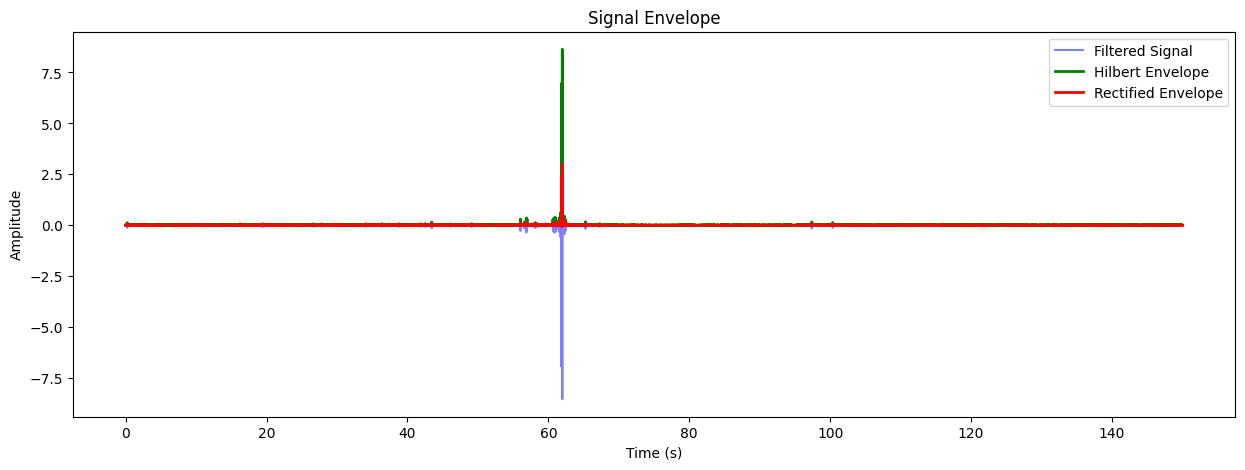

In [88]:
# using the hilbert transform 
nyquist = 0.5 * samplerate
analytic_signal = hilbert(filtered_data)
envelope_hilbert = np.abs(analytic_signal)

# using rectification and low-pass filter
cutoff_freq_envelope = 100 # # low low-pass filter to smooth the rectified signal
low_pass_cutoff = cutoff_freq_envelope / nyquist
b_lp, a_lp = butter(2, low_pass_cutoff, btype='low')
envelope_rectified = filtfilt(b_lp, a_lp, np.abs(filtered_data))

# visualize the envelopes
plt.figure(figsize=(15, 5))
plt.plot(time, filtered_data, 'b-', label='Filtered Signal', alpha=0.5)
plt.plot(time, envelope_hilbert, 'g-', linewidth=2, label='Hilbert Envelope')
plt.plot(time, envelope_rectified, 'r-', linewidth=2, label='Rectified Envelope')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Signal Envelope")
plt.legend(loc='upper right')
#plt.xlim(42.4, 42.7)
#plt.ylim(-5, 5)
plt.savefig("calibration_plots/floods/f5/f5_signal_envelopes_full.png", dpi=300)
plt.show()

Pulse counting and rectangular waveform

In [89]:
# channel gains (relative multipliers) from 
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

# voltage thresholds for impulse detection
lower_thresh = 2  # volts

# first column of results is the time index of detected impulses
rect_hilbert = pd.DataFrame({'time': time})
rect_rectified = pd.DataFrame({'time': time})

# loop over channels, apply gain, and detect impulses
# for hilbert envelope
for ch, gain in gains.items():
    amplified = envelope_hilbert * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_hilbert[f'ch{ch}'] = rectangular

# for rectified envelope
for ch, gain in gains.items():
    amplified = envelope_rectified * gain
    # create binary array: 1 if in threshold, else 0
    binary = ((amplified > lower_thresh)).astype(int)
    # convert to 5 V pulse
    rectangular = binary * 5
    rect_rectified[f'ch{ch}'] = rectangular

del amplified, binary, rectangular, ch, gain

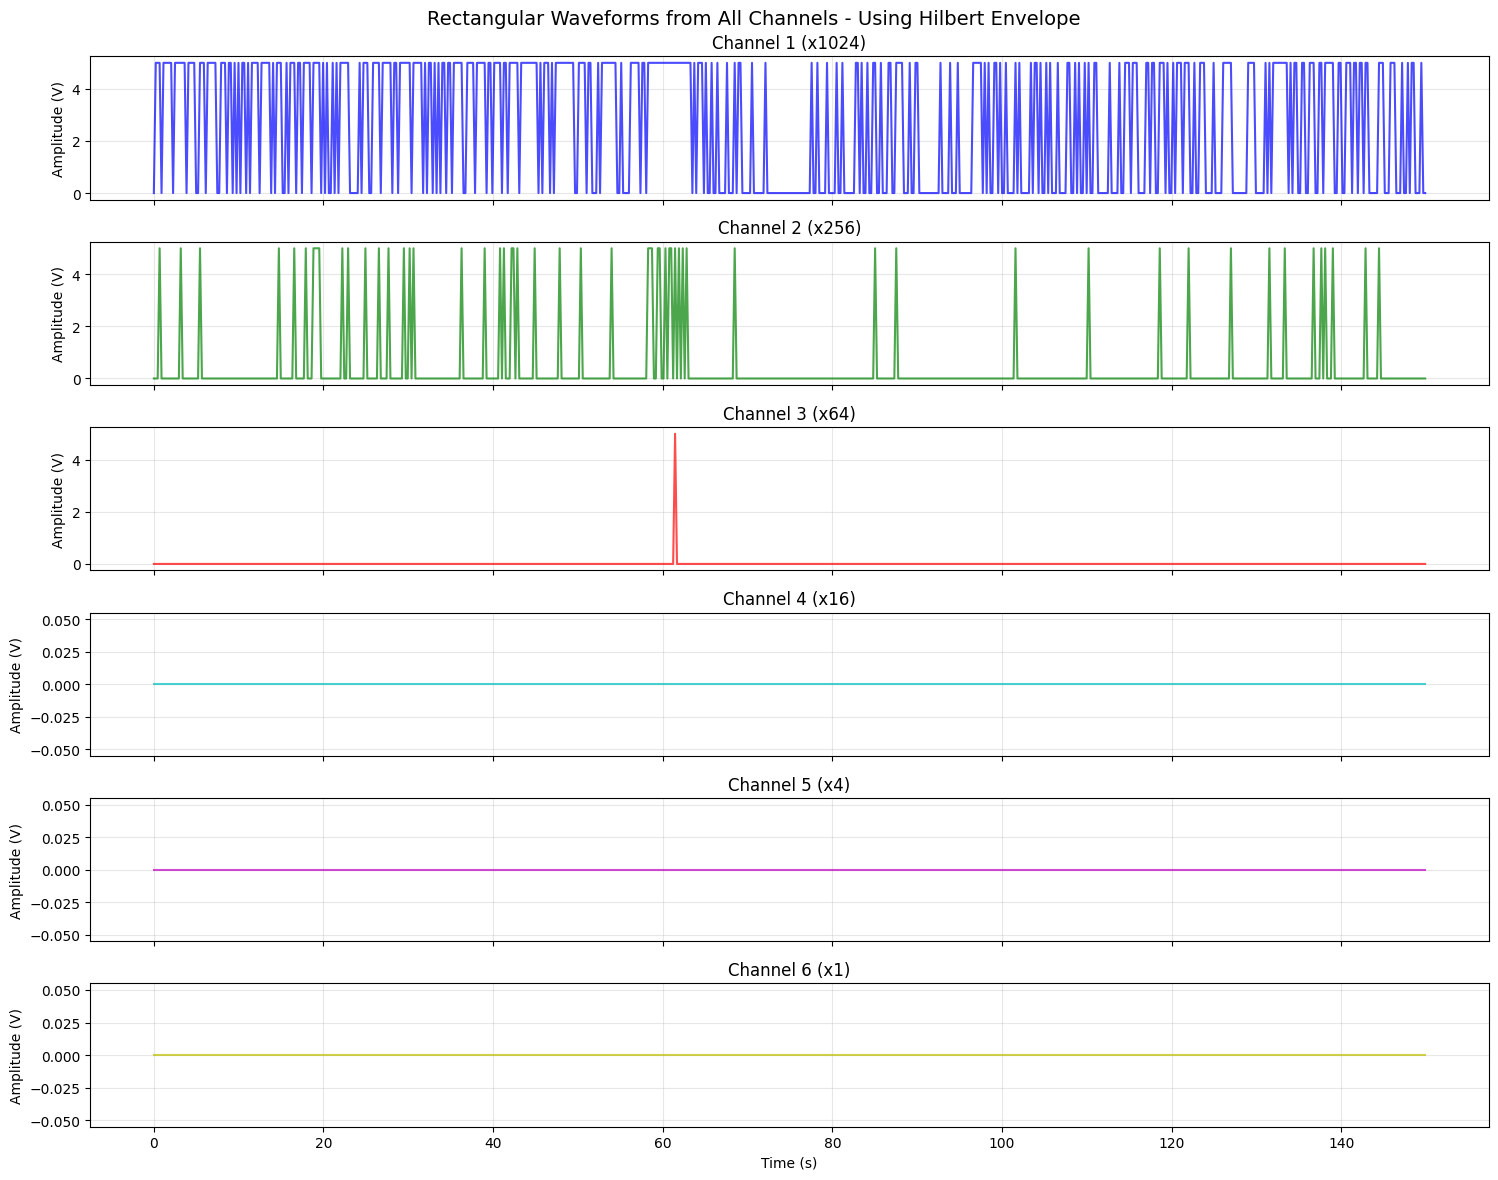

In [90]:
# visualize rect waveforms from hilbert envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000  

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_hilbert['time'][::downsample_factor]
    downsampled_signal = rect_hilbert[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Hilbert Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/floods/f5/f5_rect_from_hilbert.png", dpi=300, bbox_inches='tight')
plt.show()

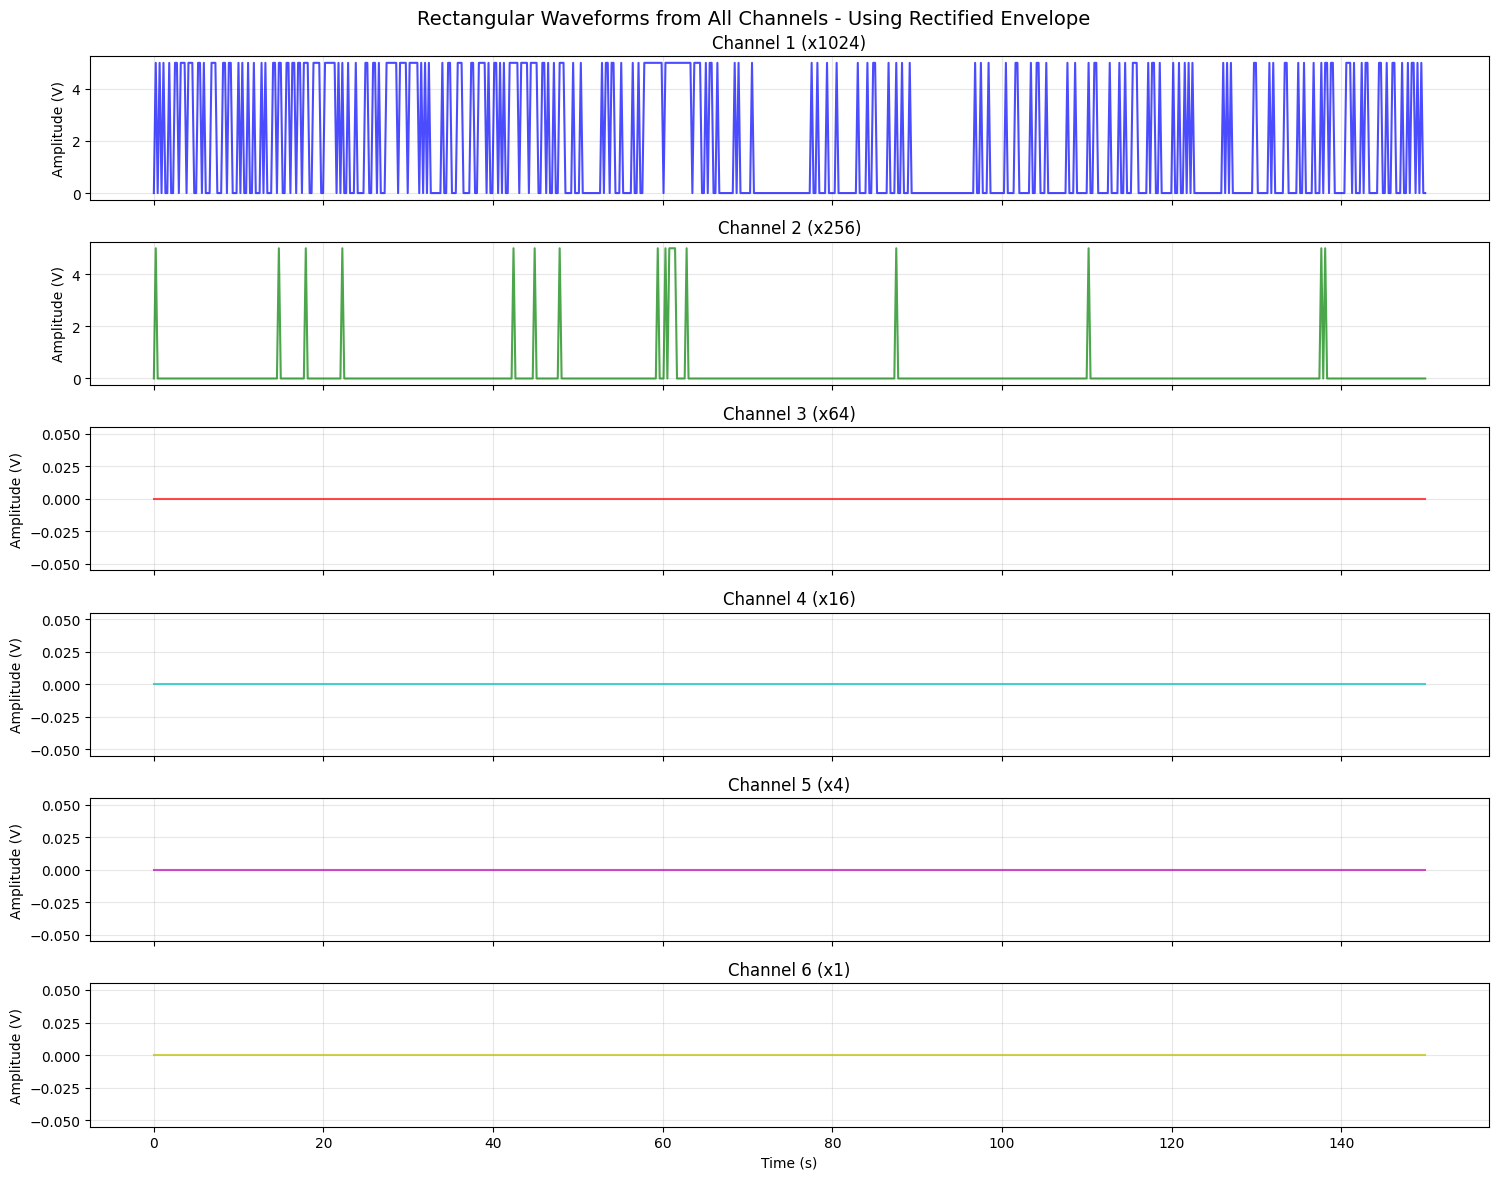

In [91]:
# visualize rect waveforms from rectified envelope (takes a while to run ~2 mins)
fig, axes = plt.subplots(6, 1, figsize=(15, 12), sharex=True)

# channel data and colors
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6']
colors = ['b', 'g', 'r', 'c', 'm', 'y']
gains = [1024, 256, 64, 16, 4, 1]
downsample_factor = 10000 

for i, (ch, color, gain) in enumerate(zip(channels, colors, gains)):
    # downsample data for plotting to reduce memory usage
    downsampled_time = rect_rectified['time'][::downsample_factor]
    downsampled_signal = rect_rectified[ch][::downsample_factor]

    axes[i].plot(downsampled_time, downsampled_signal, color=color, alpha=0.7)
    axes[i].set_ylabel("Amplitude (V)")
    axes[i].set_title(f"Channel {i+1} (x{gain})")
    axes[i].grid(True, alpha=0.3)
    # axes[i].set_ylim(0, 5.5)

# only set xlabel for bottom subplot
axes[-1].set_xlabel("Time (s)")

# zoom in on a specific time range
# for ax in axes:
#     ax.set_xlim(41.2, 42)

plt.suptitle("Rectangular Waveforms from All Channels - Using Rectified Envelope", fontsize=14)
plt.tight_layout()
plt.savefig("calibration_plots/floods/f5/f5_rect_from_rectified.png", dpi=300, bbox_inches='tight')
plt.show()

Counting pulses by particle impact

In [92]:
gains = {
    6: 1,
    5: 4,
    4: 16,
    3: 64,
    2: 256,
    1: 1024
}

fs = samplerate  # sampling frequency (Hz)
dt = 1.0         # target bin size in seconds

# build bins
time_bins = np.arange(time[0], time[-1] + dt, dt)
time_index = pd.to_timedelta(time_bins[:-1], unit="s")

# function to count impulses (rising edges) per second
def count_impulses(rect_signal, fs):
    # detect rising edges: 0→5 transitions
    rising_edges = np.diff((rect_signal > 0).astype(int)) == 1
    edge_times = time[1:][rising_edges]
    # bin counts into 1s intervals
    counts, _ = np.histogram(edge_times, bins=time_bins)
    return counts

# prepare output containers
results_hilbert = pd.DataFrame(index=time_index)
results_rectified = pd.DataFrame(index=time_index)
df_env = pd.DataFrame(index=pd.to_timedelta(time, unit="s"))

# 1) count impulses
for ch, gain in gains.items():
    impulses = count_impulses(rect_hilbert[f"ch{ch}"].values, fs)
    results_hilbert[f"impulses_ch{ch}"] = impulses

    impulses = count_impulses(rect_rectified[f"ch{ch}"].values, fs)
    results_rectified[f"impulses_ch{ch}"] = impulses
    # per-channel rect (0–5 V pulse train)
    df_env[f"hil_rect_ch{ch}"] = rect_hilbert[f"ch{ch}"]
    df_env[f"rect_rect_ch{ch}"] = rect_rectified[f"ch{ch}"]
    # per-channel envelope (apply gain to original envelopes)
    df_env[f"hil_env_ch{ch}"] = envelope_hilbert * gain
    df_env[f"rect_env_ch{ch}"] = envelope_rectified * gain

# 2) average envelope amplitude at 1 Hz
# put both hilbert + rectified envelopes into one structure
df_env_combined = pd.DataFrame({
    "time": time,
    "hilbert": envelope_hilbert,
    "rectified": envelope_rectified
})

# resample to 1 Hz (average every second)
df_env_combined.index = pd.to_timedelta(df_env_combined["time"], unit="s")
df_env_1hz = df_env_combined.resample("1s").mean()

# final result: combine counts + averages
final_hilbert = results_hilbert.join(df_env_1hz["hilbert"])
final_rectified = results_rectified.join(df_env_1hz["rectified"])

For Hilbert Envelope by Channel

In [93]:
# add rectangular waveforms to final_hilbert
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_hilbert index
    rect_series = pd.Series(rect_hilbert[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_hilbert * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_hilbert[f"env_ch{ch}"] = env_series.resample("1s").mean()

# analyze the entire sampling period as one window
t0 = time.min()  # start of entire period
t1 = time.max()  # end of entire period (should be ~480s)

# use the entire final_hilbert dataframe as the window
window = final_hilbert

# sum impulses per channel over entire period
impulse_sums = window.filter(like="impulses_ch").sum()

# amplitude stats (full envelope during entire period)
max_amp = window["hilbert"].max()
mean_amp = window["hilbert"].mean()
median_amp = window["hilbert"].median()

# collect everything
result = {
    "SampleID": "flood5",  # or whatever identifier you want
    "t0": t0,
    "t1": t1,
    "max_amp": max_amp,
    "mean_amp": mean_amp,
    "median_amp": median_amp,
}
result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses for entire period
for ch in gains.keys():
    rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
    env_col  = f"env_ch{ch}"       # envelope for this channel

    # get rect + envelope for entire period
    rect_sig = final_hilbert[f"rect_ch{ch}"]
    env_sig  = final_hilbert[f"env_ch{ch}"]

    # take only times when impulse (rect = 5V)
    mask = rect_sig > 0 # impulses
    if mask.any():
        result[f"ch{ch}_max"]   = env_sig[mask].max()
        result[f"ch{ch}_mean"]   = env_sig[mask].mean()
        result[f"ch{ch}_median"] = env_sig[mask].median()
    else:
        result[f"ch{ch}_max"]   = np.nan
        result[f"ch{ch}_mean"]   = np.nan
        result[f"ch{ch}_median"] = np.nan

# create single-row dataframe
df_results = pd.DataFrame([result])
df_results.to_csv("EXP-09-21-23-FLOW5/f5_results_hilbert.csv", index=False)

For Rectified Envelope by Channel

In [94]:
# add rectangular waveforms to final_rectified
for ch in gains.keys():
    # resample rectangular waveforms to 1Hz to match final_rectified index
    rect_series = pd.Series(rect_rectified[f'ch{ch}'].values, index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"rect_ch{ch}"] = rect_series.resample("1s").max()  # use max to preserve 5V pulses
    # add per-channel envelopes (amplified by gain)
    env_series = pd.Series(envelope_rectified * gains[ch], index=pd.to_timedelta(time, unit="s"))
    final_rectified[f"env_ch{ch}"] = env_series.resample("1s").mean()

# analyze the entire sampling period as one window
t0 = time.min()  # start of entire period
t1 = time.max()  # end of entire period (should be ~480s)

# use the entire final_rectified dataframe as the window
window = final_rectified

# sum impulses per channel over entire period
impulse_sums = window.filter(like="impulses_ch").sum()

# amplitude stats (full envelope during entire period)
max_amp = window["rectified"].max()
mean_amp = window["rectified"].mean()
median_amp = window["rectified"].median()

# collect everything
result = {
    "SampleID": "flood5",  # or whatever identifier you want
    "t0": t0,
    "t1": t1,
    "max_amp": max_amp,
    "mean_amp": mean_amp,
    "median_amp": median_amp,
}
result.update(impulse_sums.to_dict()) # add channel impulse counts

# mean and median envelope during impulses for entire period
for ch in gains.keys():
    rect_col = f"rect_ch{ch}"      # store rect waveforms per channel
    env_col  = f"env_ch{ch}"       # envelope for this channel

    # get rect + envelope for entire period
    rect_sig = final_rectified[f"rect_ch{ch}"]
    env_sig  = final_rectified[f"env_ch{ch}"]

    # take only times when impulse (rect = 5V)
    mask = rect_sig > 0 # impulses
    if mask.any():
        result[f"ch{ch}_max"]   = env_sig[mask].max()
        result[f"ch{ch}_mean"]   = env_sig[mask].mean()
        result[f"ch{ch}_median"] = env_sig[mask].median()
    else:
        result[f"ch{ch}_max"]   = np.nan
        result[f"ch{ch}_mean"]   = np.nan
        result[f"ch{ch}_median"] = np.nan

# create single-row dataframe
df_results = pd.DataFrame([result])
df_results.to_csv("EXP-09-21-23-FLOW5/f5_results_rectified.csv", index=False)

### Flood 6

In [95]:
filepath = 'EXP-09-22-23-FLOW6/audio/Nicole_091823-000100.flac'


In [ ]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB) PIPE 
right_gain_db = 2 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe


In [ ]:
start_time = 200  # in seconds
end_time = 400  # in seconds


### Flood 8

In [ ]:
filepath = 'EXP-09-22-23-FLOW8/audio/Nicole_091823-000100.flac'

In [ ]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe


In [ ]:
start_time = 100  # in seconds
end_time = 300  # in seconds


### Flood 9

In [ ]:
filepath = 'EXP-09-22-23-FLOW9/Nicole_414.wav'

In [ ]:
# === USER INPUT ===
left_gain_db = 30   # left channel gain (dB)
right_gain_db = 2 # right channel gain (dB)
use_channel = "left"  # which one was the impact pipe

In [ ]:
start_time = 50  # in seconds
end_time = 250  # in seconds